
# Simple, Reproducible Baseline: Proposal Outcome Agent + Community Stance + Ensemble

**Last generated:** 2025-10-19 22:48:25

This notebook implements a *minimal, defensible* pipeline for your thesis experiments:

1. **Proposal Outcome Agent** — DistilBERT classifier trained on proposal title+body to predict outcome labels.
2. **Community Stance Agent** — Per-post sentiment on Aave discussions aggregated to per-proposal stance scores.
3. **Ensemble (Baseline)** — A one-parameter interpolated combiner between Proposal Agent confidence and Stance score.

**GPU-ready:** Uses PyTorch + Hugging Face with automatic CUDA detection and AMP.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Proposal Outcome Agent###

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 135.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 34.3 MB/s eta 0:00:00
DATA_PROPOSALS: /content/drive/MyDrive/finalExperiment9/proposals_parsed.jsonl
DATA_AAVE_POSTS: /content/drive/MyDrive/daoDataset/aave_proposals_with_posts_fixed.jsonl
ARTIFACTS_DIR: /content/drive/MyDrive/finalExperiment9
MODEL_DIR: /content/drive/MyDrive/finalExperiment9/models/proposal_outcome_distilbert
                                                          proposal_id  label  label_int                                                                                                                                                                                                              

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Sizes: 13024 1628 1629
Using device: cuda | mixed precision: fp16


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: train_loss=0.8841 val_acc=0.7647 val_macroF1=0.5371
Epoch 2: train_loss=0.7507 val_acc=0.7033 val_macroF1=0.5137
Epoch 3: train_loss=0.6281 val_acc=0.7211 val_macroF1=0.5402
Best val macro-F1: 0.5402033739758103
Test Accuracy: 0.7397
Test Macro-F1: 0.5643
              precision    recall  f1-score   support

        fail     0.3848    0.6231    0.4758       268
     abstain     0.3182    0.4667    0.3784        60
        pass     0.9124    0.7763    0.8389      1301

    accuracy                         0.7397      1629
   macro avg     0.5385    0.6220    0.5643      1629
weighted avg     0.8037    0.7397    0.7622      1629

Saved figure: /content/drive/MyDrive/finalExperiment9/proposal_outcome_confusion_matrix.png
Saved predictions: /content/drive/MyDrive/finalExperiment9/proposal_outcome_test_predictions.csv
Saved metrics: /content/drive/MyDrive/finalExperiment9/proposal_outcome_metrics.json
Saved label map: /content/drive/MyDrive/finalExperiment9/label_map.json
Saved mo

/tmp/ipython-input-3844665620.py:402: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat() + "Z",


Saved run config: /content/drive/MyDrive/finalExperiment9/proposal_outcome_run_config.json
Saved top error examples: /content/drive/MyDrive/finalExperiment9/proposal_outcome_top_errors.csv


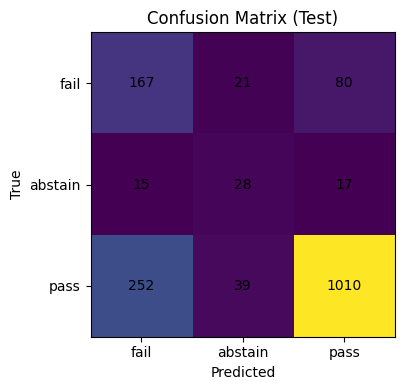

In [ ]:
# # Proposal Outcome Classifier (DistilBERT)
# Final, cleaned version for thesis deliverables.
#
# **What this notebook does**
# - Loads DAO proposal data (title + body) and maps labels to {fail, abstain, pass}.
# - Cleans text (strip HTML and quoted markdown).
# - Fine-tunes DistilBERT with class-weighted loss for imbalance.
# - Stratified splits with deterministic seeds.
# - Evaluates on a held-out test set (Accuracy, Macro-F1, classification report).
# - Saves calibrated probabilities for ensemble usage + artifacts to Drive.
#
# **Key implementation notes**
# - Uses `accelerate` (mixed precision on GPU).
# - Uses class weights and keeps the best-epoch state by val Macro-F1.
# - Unwraps the model before saving for HF compatibility.
# - Gathers predictions, labels, **and** probabilities across processes.
# - Captures `id2label/label2id` in the saved model config and a JSON.
# - Produces a confusion matrix and saves metrics + run config.


# ## 0) Environment & Installs

!pip -q install transformers datasets accelerate evaluate bs4 --upgrade

# ## 1) Imports & Global Config

import os
import json
import random
import re
import html
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)
from accelerate import Accelerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score
)

from bs4 import BeautifulSoup

# ---- Reproducibility / Determinism ----
RANDOM_SEED = 42
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ---- Task / Train Config ----
MAX_LEN = 512
BATCH_SIZE = 8           # increase if larger GPU
EPOCHS = 3               # can tune to 3-5
LR = 2e-5
WEIGHT_DECAY = 0.01
MODEL_NAME = "distilbert-base-uncased"

# ---- Data paths (env overrideable) ----
# Keep your original env vars but make Drive paths consistent and absolute for Colab.
DATA_PROPOSALS = os.getenv("DATA_PROPOSALS", "/content/drive/MyDrive/finalExperiment9/proposals_parsed.jsonl")
DATA_AAVE_POSTS = os.getenv("DATA_AAVE_POSTS", "/content/drive/MyDrive/daoDataset/aave_proposals_with_posts_fixed.jsonl")  # loaded (currently unused)
ARTIFACTS_DIR = Path("/content/drive/MyDrive/finalExperiment9/")
MODEL_DIR = Path("/content/drive/MyDrive/finalExperiment9/models/proposal_outcome_distilbert")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)

print("DATA_PROPOSALS:", DATA_PROPOSALS)
print("DATA_AAVE_POSTS:", DATA_AAVE_POSTS)
print("ARTIFACTS_DIR:", ARTIFACTS_DIR.resolve())
print("MODEL_DIR:", MODEL_DIR.resolve())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


# ## 2) Text Cleaning Utilities

def strip_html(text: str) -> str:
    text = text or ""
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text(separator=" ", strip=True)

def strip_blockquotes_md(text: str) -> str:
    # Remove lines that start with '>' (markdown blockquotes)
    lines = (text or "").splitlines()
    kept = [ln for ln in lines if not ln.strip().startswith(">")]
    return "\n".join(kept)

def clean_text(raw: str, cooked_html: str = None) -> str:
    t = raw if (raw and str(raw).strip()) else (cooked_html or "")
    t = strip_blockquotes_md(t)
    t = strip_html(t)
    t = html.unescape(t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

def compose_text(row):
    # Use cleaners on title + body
    raw = f"{(row.get('title') or '')}\n\n{(row.get('body') or '')}"
    return clean_text(raw)


# ## 3) Load Data & Prepare Splits

# Load proposals
proposals = pd.read_json(DATA_PROPOSALS, lines=True)

# Load Aave posts (kept to not lose original work; currently unused in this classifier)
aave_posts = pd.read_json(DATA_AAVE_POSTS, lines=True)

# Label mapping: 0.0 = fail, 1.0 = abstain/other, 2.0 = pass
LABEL_MAP = {0.0: 0, 1.0: 1, 2.0: 2}
INV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}

# Drop rows with missing label and map to ints
proposals_clean = proposals.copy()
proposals_clean = proposals_clean[proposals_clean['label'].notna()].copy()
proposals_clean['label_int'] = proposals_clean['label'].map(LABEL_MAP)
proposals_clean = proposals_clean[proposals_clean['label_int'].notna()].copy()
proposals_clean['label_int'] = proposals_clean['label_int'].astype(int)

# Compose cleaned text
proposals_clean['text'] = proposals_clean.apply(compose_text, axis=1)

# Ensure 'title' and 'body' are always present in proposals_clean for downstream use
# (as split dataframes might lose them or they might be implicitly dropped by pandas display)
# This is a robust way to ensure they exist before splitting.
proposals_clean = proposals_clean.merge(
    proposals[['proposal_id', 'title', 'body']],
    on='proposal_id',
    how='left',
    suffixes=('_old', '')
)
# Handle potential duplicates if 'title' and 'body' were already present
if 'title_old' in proposals_clean.columns: # This means they were present before merge
    # Use the non-_old version, it might be the desired original
    proposals_clean['title'] = proposals_clean['title'].fillna(proposals_clean['title_old'])
    proposals_clean.drop(columns='title_old', inplace=True)
if 'body_old' in proposals_clean.columns:
    proposals_clean['body'] = proposals_clean['body'].fillna(proposals_clean['body_old'])
    proposals_clean.drop(columns='body_old', inplace=True)


# Basic preview (optional)
display_cols = ['proposal_id','label','label_int','text', 'title', 'body'] # Added title and body here for clearer preview
print(proposals_clean[display_cols].head(2).to_string())

# Stratified train/val/test split
train_df, temp_df = train_test_split(
    proposals_clean,
    test_size=0.20,
    stratify=proposals_clean['label_int'],
    random_state=RANDOM_SEED
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df['label_int'],
    random_state=RANDOM_SEED
)

print("Class ratios (train/val/test):")
print(
    train_df['label_int'].value_counts(normalize=True).sort_index(),
    val_df['label_int'].value_counts(normalize=True).sort_index(),
    test_df['label_int'].value_counts(normalize=True).sort_index(),
    sep="\n"
)

# ## 4) Dataset & Dataloaders

class ProposalDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return item

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_ds = ProposalDataset(train_df['text'].tolist(), train_df['label_int'].tolist(), tokenizer, MAX_LEN)
val_ds   = ProposalDataset(val_df['text'].tolist(),   val_df['label_int'].tolist(),   tokenizer, MAX_LEN)
test_ds  = ProposalDataset(test_df['text'].tolist(),  test_df['label_int'].tolist(),  tokenizer, MAX_LEN)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

print("Sizes:", len(train_ds), len(val_ds), len(test_ds))

# ## 5) Class Weights (safer) & Accelerator Setup

# Safer class weights: handle rare edge-cases if a class is missing in the train split
class_counts = train_df['label_int'].value_counts().sort_index()
num_classes = 3
total = class_counts.sum()
min_nonzero = max(1, int(class_counts.min()))  # floor to 1

class_weights = torch.tensor([
    total / (num_classes * int(class_counts.get(i, min_nonzero)))
    for i in range(num_classes)
], dtype=torch.float)

accelerator = Accelerator(mixed_precision="fp16" if torch.cuda.is_available() else "no")
accelerator.print("Using device:", accelerator.device, "| mixed precision:", accelerator.mixed_precision)

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
model.to(accelerator.device)
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Scheduler
num_training_steps = EPOCHS * len(train_loader)
num_warmup_steps = int(0.1 * num_training_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)

# Prepare ALL loaders + model/opt/sched with Accelerator
train_loader, val_loader, test_loader, model, optimizer, scheduler = accelerator.prepare(
    train_loader, val_loader, test_loader, model, optimizer, scheduler
)

# Weighted CE loss on accelerator device
loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(accelerator.device))

# For readable labels in saved model
id2label = {0: "fail", 1: "abstain", 2: "pass"}
label2id = {v: k for k, v in id2label.items()}
model.config.id2label = id2label
model.config.label2id = label2id


# ## 6) Training Loop (keep best state by val Macro-F1)
best_val_f1 = -1.0
best_state = None

for epoch in range(1, EPOCHS + 1):
    # ---- Train ----
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()
        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        )
        logits = outputs.logits
        loss = loss_fct(logits, batch["labels"])
        accelerator.backward(loss)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)

    # ---- Validate ----
    model.eval()
    preds, gts = [], []
    with torch.no_grad():
        for batch in val_loader:
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"]
            )
            logits = outputs.logits
            pred = torch.argmax(logits, dim=-1)
            preds.extend(accelerator.gather(pred).cpu().numpy().tolist())
            gts.extend(accelerator.gather(batch["labels"]).cpu().numpy().tolist())

    val_f1 = f1_score(gts, preds, average="macro")
    val_acc = accuracy_score(gts, preds)
    accelerator.print(f"Epoch {epoch}: train_loss={avg_train_loss:.4f} val_acc={val_acc:.4f} val_macroF1={val_f1:.4f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        # keep a CPU copy of best weights
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}

# Load best
if best_state is not None:
    model.load_state_dict(best_state)
accelerator.print("Best val macro-F1:", best_val_f1)

# ## 7) Test Evaluation
model.eval()
test_preds, test_gts, test_probs = [], [], []
softmax = torch.nn.Softmax(dim=-1)

with torch.no_grad():
    for batch in test_loader:
        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        )
        logits = outputs.logits
        prob = softmax(logits)
        pred = torch.argmax(prob, dim=-1)

        # Gather across processes for distributed correctness
        test_preds.extend(accelerator.gather(pred).cpu().numpy().tolist())
        test_gts.extend(accelerator.gather(batch["labels"]).cpu().numpy().tolist())
        test_probs.extend(accelerator.gather(prob).cpu().numpy().tolist())

test_acc = accuracy_score(test_gts, test_preds)
test_f1 = f1_score(test_gts, test_preds, average="macro")

print("Test Accuracy:", round(test_acc, 4))
print("Test Macro-F1:", round(test_f1, 4))
print(classification_report(test_gts, test_preds, digits=4, target_names=[id2label[i] for i in range(3)]))

## 8) Confusion Matrix (Figure)
cm = confusion_matrix(test_gts, test_preds, labels=[0,1,2])
fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(cm, interpolation='nearest')
ax.set_title("Confusion Matrix (Test)")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_xticks([0,1,2])
ax.set_yticks([0,1,2])
ax.set_xticklabels([id2label[i] for i in range(3)])
ax.set_yticklabels([id2label[i] for i in range(3)])

# Write counts
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
fig_path = ARTIFACTS_DIR / "proposal_outcome_confusion_matrix.png"
plt.savefig(fig_path, dpi=150)
print("Saved figure:", fig_path.resolve())

## 9) Save Predictions, Metrics, Model, and Run Config
# Predictions for ensemble
test_ids = test_df['proposal_id'].tolist()
pred_df = pd.DataFrame(test_probs, columns=["P_fail","P_abstain","P_pass"])
pred_df["y_pred"] = test_preds
pred_df["y_true"] = test_gts
pred_df["proposal_id"] = test_ids
pred_path = ARTIFACTS_DIR / "proposal_outcome_test_predictions.csv"
pred_df.to_csv(pred_path, index=False)
print("Saved predictions:", pred_path.resolve())

# Metrics
metrics = {
    "test_acc": float(test_acc),
    "test_macro_f1": float(test_f1),
    "best_val_macro_f1": float(best_val_f1),
}
with open(ARTIFACTS_DIR / "proposal_outcome_metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)
print("Saved metrics:", (ARTIFACTS_DIR / "proposal_outcome_metrics.json").resolve())

# Save label maps (explicit)
with open(ARTIFACTS_DIR / "label_map.json", "w") as f:
    json.dump({"id2label": id2label, "label2id": label2id}, f, indent=2)
print("Saved label map:", (ARTIFACTS_DIR / "label_map.json").resolve())

# Save model/tokenizer (unwrap first)
unwrapped = Accelerator().unwrap_model(model)  # safe unwrap in case of distributed context
unwrapped.config.id2label = id2label
unwrapped.config.label2id = label2id
unwrapped.save_pretrained(MODEL_DIR)
tokenizer.save_pretrained(MODEL_DIR)
print("Saved model to:", MODEL_DIR.resolve())

# Save run config for reproducibility
run_config = {
    "timestamp": datetime.utcnow().isoformat() + "Z",
    "seed": RANDOM_SEED,
    "max_len": MAX_LEN,
    "batch_size": BATCH_SIZE,
    "epochs": EPOCHS,
    "lr": LR,
    "weight_decay": WEIGHT_DECAY,
    "model_name": MODEL_NAME,
    "data_proposals": DATA_PROPOSALS,
    "data_aave_posts": DATA_AAVE_POSTS,
    "artifacts_dir": str(ARTIFACTS_DIR.resolve()),
    "model_dir": str(MODEL_DIR.resolve()),
}
with open(ARTIFACTS_DIR / "proposal_outcome_run_config.json", "w") as f:
    json.dump(run_config, f, indent=2)
print("Saved run config:", (ARTIFACTS_DIR / "proposal_outcome_run_config.json").resolve())


# 10) (Optional) Sanity Checks / Peeks

# Peek worst mistakes (optional, useful for qualitative analysis)
try:
    test_texts = test_df['text'].tolist()
    df_err = pd.DataFrame({
        "proposal_id": test_ids,
        "true": [id2label[i] for i in test_gts],
        "pred": [id2label[i] for i in test_preds],
        "P_fail": [p[0] for p in test_probs],
        "P_abstain": [p[1] for p in test_probs],
        "P_pass": [p[2] for p in test_probs],
        "text": test_texts
    })
    df_err["correct"] = df_err["true"] == df_err["pred"]
    worst = df_err[~df_err["correct"]].sort_values(by=["P_fail","P_abstain","P_pass"], ascending=False).head(10)
    err_path = ARTIFACTS_DIR / "proposal_outcome_top_errors.csv"
    worst.to_csv(err_path, index=False)
    print("Saved top error examples:", err_path.resolve())
except Exception as e:
    print("Skip error table:", e)


/tmp/ipython-input-2897185204.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


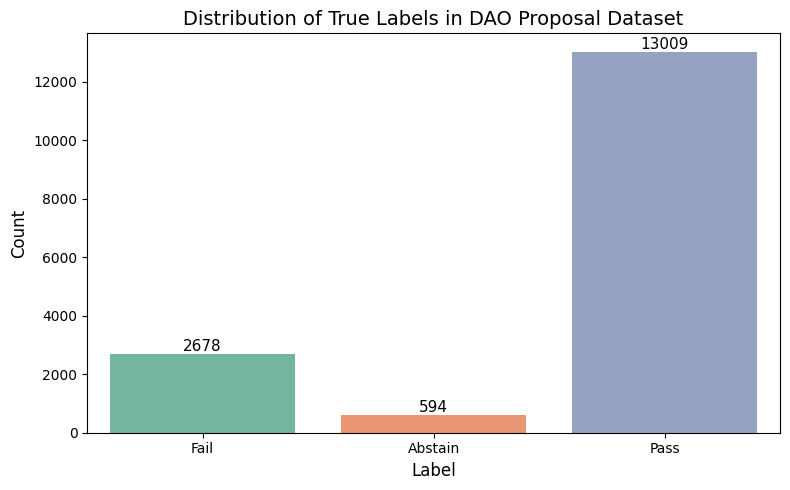

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Optional: modify based on your actual label map
label_map = {
    0: "Fail",
    1: "Abstain",
    2: "Pass"
}

# Apply the label map if needed
proposals_clean["label_name"] = proposals_clean["label_int"].map(label_map)

plt.figure(figsize=(8, 5))
sns.countplot(
    data=proposals_clean,
    x="label_name",
    order=["Fail", "Abstain", "Pass"],
    palette="Set2"
)

plt.title("Distribution of True Labels in DAO Proposal Dataset", fontsize=14)
plt.xlabel("Label", fontsize=12)
plt.ylabel("Count", fontsize=12)

for container in plt.gca().containers:
    plt.gca().bar_label(container, fontsize=11)

plt.tight_layout()
plt.show()


In [ ]:
# === Extra: Proposal agent per-class F1 table + bar chart ===
from sklearn.metrics import classification_report

# Recompute with output_dict so we can save it
report_prop = classification_report(
    test_gts,
    test_preds,
    output_dict=True,
    target_names=[id2label[i] for i in range(3)]
)

# Save full classification report as CSV
import pandas as pd
report_prop_df = pd.DataFrame(report_prop).T
metrics_path = ARTIFACTS_DIR / "proposal_agent_classification_report.csv"
report_prop_df.to_csv(metrics_path, index=True)
print("Saved:", metrics_path.resolve())

# Simple bar chart of per-class F1
class_labels = [id2label[i] for i in range(3)]
f1_values = [report_prop[label]["f1-score"] for label in class_labels]

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
ax.bar(class_labels, f1_values)
ax.set_ylabel("F1-score")
ax.set_ylim(0, 1)
ax.set_title("Per-class F1 — Proposal Outcome Agent")
for i, v in enumerate(f1_values):
    ax.text(i, v + 0.02, f"{v:.2f}", ha="center", fontsize=9)
plt.tight_layout()
prop_f1_path = ARTIFACTS_DIR / "proposal_agent_f1_per_class.png"
plt.savefig(prop_f1_path)
plt.close()
print("Saved:", prop_f1_path.resolve())

Saved: /content/drive/MyDrive/finalExperiment9/proposal_agent_classification_report.csv
Saved: /content/drive/MyDrive/finalExperiment9/proposal_agent_f1_per_class.png


In [ ]:
# === NEWEST VERSION OF COMMUNITY AGENT Argumentative sentence mining + stance scoring (FAST + CAPPED) ===
import re, math, json, numpy as np, pandas as pd, torch, os, gc, time
from tqdm.auto import tqdm
from transformers import pipeline as hf_pipeline
from pathlib import Path


# ---------------- Config knobs ----------------
MAX_POSTS_PER_PROPOSAL   = 40    # cap evidence posts used per proposal
MAX_SENTS_PER_POST       = 8     # cap candidate sentences per post (slightly tighter for quality)
GLOBAL_SENT_CAP          = 60000 # absolute cap across the whole corpus
BATCH_SIZE               = 128   # HF pipeline batch size
MIN_WORDS                = 8     # filter short sentences
MAX_WORDS                = 60    # filter very long sentences (avoid multi-paragraph blobs)
USE_MMR                  = True  # diversify sentences per proposal
MMR_K                    = 100   # keep top-K sentences per proposal after MMR
SAVE_SENT_PARQUET        = True
SENT_PARQUET_PATH        = ARTIFACTS_DIR / "stance_sentence_candidates.csv"
SCORES_PARQUET_PATH      = ARTIFACTS_DIR / "stance_sentence_scores.csv"
RNG                      = np.random.default_rng(42)

# ---------------- Sentiment model selection ----------------
# Prefer finance/governance-relevant sentiment models, then fall back to generic.
MODEL_SENTIMENTS = [
    "ProsusAI/finbert",
    "yiyanghkust/finbert-tone",
    "cardiffnlp/twitter-roberta-base-sentiment-latest",
    "distilbert-base-uncased-finetuned-sst-2-english",
]

def save_table(df: pd.DataFrame, path):
    path = Path(path)
    if path.suffix.lower() != ".csv":
        path = path.with_suffix(".csv")
    df.to_csv(path, index=False)
    return path

def load_table(path):
    path = Path(path)
    if path.suffix.lower() != ".csv":
        path = path.with_suffix(".csv")
    return pd.read_csv(path)

def get_sentiment_pipeline():
    for m in MODEL_SENTIMENTS:
        try:
            print("Trying sentiment model:", m)
            return hf_pipeline(
                "sentiment-analysis",
                model=m,
                device=0 if torch.cuda.is_available() else -1,
                truncation=True
            )
        except Exception as e:
            print("Could not load", m, "->", e)
    # final fallback: default sentiment model
    return hf_pipeline("sentiment-analysis", device=0 if torch.cuda.is_available() else -1)

sent_pipe = get_sentiment_pipeline()
print("Loaded sentiment model:", getattr(getattr(sent_pipe, "model", None), "name_or_path", "unknown"))

# ---------------- Helpers ----------------
_WORDS = re.compile(r"\w+")
_URL   = re.compile(r"https?://\S+")
TAGGY  = re.compile(r"^[#>\-\*•\s]+")

IMAGE_MD = re.compile(r"^!\[.*?\]\(.*?\)")
UPLOAD_TOKEN = "upload://"

META_PREFIXES = [
    "title:", "author:", "delegates:", "delegate:", "disclaimer:",
    "about this proposal", "summary:", "motivation:", "abstract:"
]

def clean_sentence_for_arguments(s: str) -> str:
    s = (s or "").strip()

    # Strip image markdown or uploads
    if IMAGE_MD.match(s) or UPLOAD_TOKEN in s:
        return ""

    # Remove bare markdown links [text](url)
    s = re.sub(r"\[([^\]]+)\]\([^)]+\)", r"\1", s)

    # Remove leading markdown bullets / hashes
    s = re.sub(r"^[#>\-\*•\s]+", "", s)

    # Drop obvious meta/header lines
    low = s.lower()
    for pref in META_PREFIXES:
        if low.startswith(pref):
            return ""

    # Normalize whitespace
    s = re.sub(r"\s+", " ", s).strip()
    return s

def split_sentences(txt: str):
    """Lightweight sentence splitter good enough for forum text."""
    txt = (txt or "").strip()
    if not txt:
        return []
    parts = re.split(r'(?<=[.!?])\s+', txt)
    return [p.strip() for p in parts if p.strip()]

def is_claim_like(s: str) -> bool:
    if TAGGY.match(s): return False
    w = _WORDS.findall(s)
    if not (MIN_WORDS <= len(w) <= MAX_WORDS): return False
    if _URL.search(s) and len(w) < (MIN_WORDS + 4): return False
    letters = sum(c.isalpha() for c in s)
    if letters / max(1, len(s)) < 0.55: return False
    return True

def mmr_select(strings, k=MMR_K, lambda_div=0.6):
    """Very small TF-IDF-ish cosine using hashed counts; avoids sklearn deps here."""
    if not strings:
        return []
    # Hashing-bag representation
    vocab_size = 4096
    def vec(s):
        v = np.zeros(vocab_size, dtype=np.float32)
        for t in _WORDS.findall(s.lower()):
            h = hash(t) % vocab_size
            v[h] += 1.0
        if v.sum() > 0: v /= np.linalg.norm(v)
        return v
    vecs = [vec(s) for s in strings]
    N = len(vecs)
    if N <= k:
        return list(range(N))
    selected = [int(np.argmax([v.sum() for v in vecs]))]  # seed by magnitude
    cand = set(range(N)) - set(selected)
    while len(selected) < k and cand:
        best_i, best_score = None, -1e9
        for i in cand:
            sim_to_sel = max(float(np.dot(vecs[i], vecs[j])) for j in selected) if selected else 0.0
            # relevance proxy = norm; already normalized ⇒ use 1.0 - sim as diversity
            score = lambda_div * 1.0 - (1 - lambda_div) * sim_to_sel
            if score > best_score:
                best_score, best_i = score, i
        selected.append(best_i)
        cand.remove(best_i)
    return selected

# --- Governance / stance heuristics for smarter pros & cons ---
GOV_TERMS = [
    "proposal", "aip", "arfc", "snapshot",
    "market", "listing", "deploy", "deployment",
    "risk", "oracle", "liquidation", "ltv", "liquidation threshold",
    "borrow cap", "supply cap",
    "treasury", "grant", "emission", "incentive", "rewards",
    "parameter", "upgrade", "v3", "v2", "bridge"
]

PRO_HINTS = [
    "i support", "i am in support", "in favor", "in favour",
    "i agree with", "this makes sense", "good idea", "strongly support",
    "i like this proposal", "i am for", "should pass", "looks good", "sensible"
]

CON_HINTS = [
    "i oppose", "i am against", "i do not support", "i don't support",
    "i disagree", "this is risky", "this is a concern", "i am concerned",
    "should not pass", "vote against", "this worries me", "red flag",
    "too risky", "not comfortable", "i have reservations"
]

def contains_any(text: str, terms) -> bool:
    t = text.lower()
    return any(p in t for p in terms)

def governance_relevance(text: str) -> float:
    """Rough proxy: how many governance terms are mentioned."""
    t = text.lower()
    return float(sum(1 for term in GOV_TERMS if term in t))


# ---------------- Build candidate sentences with caps ----------------
# We need posts_df with columns: proposal_id, text, len (you already built this upstream).
# If you don't have it in memory, rebuild quickly from `aave_posts`.
if "posts_df" not in globals():
    rows = []
    for _, row in aave_posts.iterrows():
        pid = str(row.get("proposal_id"))
        discussions = row.get("discussions") or []
        for d in discussions:
            posts = d.get("posts") or []
            for p in posts:
                raw   = p.get("raw")
                cooked= p.get("cooked_html")
                t     = clean_text(raw, cooked)
                if t:
                    rows.append({"proposal_id": pid, "text": t, "len": len(t)})
    posts_df = pd.DataFrame(rows)
    print("Rebuilt posts_df:", posts_df.shape)

# Cap posts per proposal by length/engagement proxy (len is fine if like_count absent)
def top_posts_per_proposal(df, k=MAX_POSTS_PER_PROPOSAL):
    # Optionally: if you have like_count / reply_count, sort by that first.
    return (df.sort_values("len", ascending=False)
              .groupby("proposal_id")
              .head(k)
              .reset_index(drop=True))

posts_top = top_posts_per_proposal(posts_df, MAX_POSTS_PER_PROPOSAL)
print("Posts after per-proposal cap:", posts_top.shape)

# Explode into sentences with per-post cap and global cap
cand_rows = []
for idx, r in tqdm(posts_top.iterrows(), total=len(posts_top), desc="Mining sentences"):
    pid = str(r["proposal_id"])
    sents = split_sentences(str(r["text"]))
    cleaned = []
    for s in sents:
        s_clean = clean_sentence_for_arguments(s)
        if not s_clean:
            continue
        if is_claim_like(s_clean):
            cleaned.append(s_clean)
    sents = cleaned[:MAX_SENTS_PER_POST]

    for s in sents:
        cand_rows.append((pid, s, len(s.split())))
    # global cap early stop
    if len(cand_rows) >= GLOBAL_SENT_CAP:
        break

cand_df = pd.DataFrame(cand_rows, columns=["proposal_id","sentence","wc"])
print(f"Claim-like sentences (capped): {cand_df.shape}")

# Optional per-proposal MMR diversification
if USE_MMR:
    keep_idx = []
    for pid, g in cand_df.groupby("proposal_id"):
        idxs = list(g.index)
        strings = g["sentence"].tolist()
        sel_rel = mmr_select(strings, k=min(MMR_K, len(strings)))
        keep_idx.extend([idxs[i] for i in sel_rel])
    cand_df = cand_df.loc[sorted(set(keep_idx))].reset_index(drop=True)
    print("After MMR:", cand_df.shape)

if SAVE_SENT_PARQUET:
    save_table(cand_df, SENT_PARQUET_PATH)
    print("Saved candidates to:", SENT_PARQUET_PATH)

def score_sentences(df, pipe, batch_size=BATCH_SIZE, out_path=SCORES_PARQUET_PATH):
    """
    Score sentences with a HF sentiment pipeline.
    Uses CSV (save_table/load_table) for persistence and resumes cleanly.
    """
    df = df.copy()
    out_path = Path(out_path)
    # We always store scores as CSV
    if out_path.suffix.lower() != ".csv":
        out_path = out_path.with_suffix(".csv")

    if out_path.exists():
        # resume from existing scores
        scored = load_table(out_path)   # this already forces .csv
        # if we previously saved with reset_index(), put the index back
        if "index" in scored.columns and scored.index.name is None:
            scored = scored.set_index("index")
        done = set(scored.index)
        todo_idx = [i for i in df.index if i not in done]
        out = scored
        print(f"[resume] {len(done)} already scored; {len(todo_idx)} remaining.")
    else:
        todo_idx = list(df.index)
        out = pd.DataFrame(index=df.index, columns=["label","p_pos","p_neu","p_neg"])

    # If there's nothing new to score, just return what we already have
    if not todo_idx:
        return out

    # batch loop
    for i in tqdm(range(0, len(todo_idx), batch_size), desc="Scoring sentences"):
        idxs = todo_idx[i:i+batch_size]
        texts = df.loc[idxs, "sentence"].astype(str).tolist()
        try:
            preds = pipe(texts, batch_size=batch_size, truncation=True)
        except Exception:
            # in case pipeline doesn’t support batch_size kw
            preds = pipe(texts, truncation=True)

        # normalize to pos/neu/neg
        for j, pred in zip(idxs, preds):
            lbl = str(pred["label"]).lower()
            score = float(pred.get("score", 0.0))

            if "pos" in lbl:
                out.at[j, "label"] = "pos"
                out.at[j, "p_pos"] = score
                out.at[j, "p_neu"] = 0.0
                out.at[j, "p_neg"] = 1.0 - score
            elif "neg" in lbl:
                out.at[j, "label"] = "neg"
                out.at[j, "p_neg"] = score
                out.at[j, "p_neu"] = 0.0
                out.at[j, "p_pos"] = 1.0 - score
            else:
                # 3-way model / unknown labels → neutral-ish
                out.at[j, "label"] = "neu"
                out.at[j, "p_pos"] = 0.33
                out.at[j, "p_neu"] = 0.34
                out.at[j, "p_neg"] = 0.33

        # checkpoint every ~10 batches
        if (i // batch_size) % 10 == 0:
            save_table(out.reset_index(), out_path)

    # final save
    save_table(out.reset_index(), out_path)
    return out


scores = score_sentences(cand_df, sent_pipe, BATCH_SIZE, SCORES_PARQUET_PATH)
save_table(scores.reset_index(), SCORES_PARQUET_PATH)  # ensure a flat CSV
print("Scored sentences:", scores.shape)

# ---------------- Aggregate to per-proposal stance ----------------
tmp = cand_df.join(scores, how="left")
# weight by sentence length (or later, by likes/replies if available)
tmp["w"] = tmp["wc"].clip(lower=1).astype(float)

# numeric stance score (keep this logic so results aren't massively changed)
tmp["stance_sent"] = tmp["p_pos"] - tmp["p_neg"]

# coarse stance label for counts
tmp["stance_label"] = pd.cut(
    tmp["stance_sent"],
    bins=[-1.0, -0.15, 0.15, 1.0],
    labels=["negative", "neutral", "positive"]
)

# stricter label JUST for picking arguments (stronger polarity)
tmp["stance_label_arg"] = pd.cut(
    tmp["stance_sent"],
    bins=[-1.0, -0.35, 0.35, 1.0],
    labels=["negative", "neutral", "positive"]
)

def top_arguments(g, label, k=5):
    """
    Pick top-k sentences that clearly support/oppose the proposal.

    Uses:
      - strict sentiment (stance_label_arg)
      - sentiment magnitude
      - length (very short sentences get less weight)
      - governance relevance (parameters/oracles/treasury/etc)
      - explicit support/oppose cues (PRO_HINTS / CON_HINTS)
    """
    sub = g[g["stance_label_arg"] == label].copy()
    if sub.empty:
        return []

    rows = []
    for _, row in sub.iterrows():
        s = (row["sentence"] or "").strip()
        if not s:
            continue

        low = s.lower()
        # base: how strong is the sentiment?
        base = abs(row["stance_sent"])
        # length bonus (discourage 3-word sentences)
        wc = max(1, len(s.split()))
        length_factor = min(wc / 12.0, 2.0)  # plateau after ~24 words

        # governance relevance
        gov_score = governance_relevance(s)
        gov_factor = 1.0 + 0.25 * gov_score  # more gov terms → more weight

        # explicit stance cues
        bonus = 1.0
        if label == "positive" and contains_any(low, PRO_HINTS):
            bonus *= 2
        if label == "negative" and contains_any(low, CON_HINTS):
            bonus *= 2

        arg_weight = base * length_factor * gov_factor * bonus
        rows.append((arg_weight, s))

    if not rows:
        return []

    rows.sort(key=lambda x: x[0], reverse=True)

    out, seen = [], set()
    for _, s in rows:
        if s in seen:
            continue
        seen.add(s)
        out.append(s)
        if len(out) >= k:
            break
    return out

def top_neutral_descriptions(g, k=3):
    """
    Pick neutral sentences that describe what is being discussed
    (high governance relevance, neutral sentiment).
    """
    sub = g[g["stance_label"] == "neutral"].copy()
    if sub.empty:
        return []

    rows = []
    for _, row in sub.iterrows():
        s = (row["sentence"] or "").strip()
        if not s:
            continue
        gov_score = governance_relevance(s)
        if gov_score <= 0:
            continue
        wc = max(1, len(s.split()))
        length_factor = min(wc / 10.0, 2.0)
        weight = gov_score * length_factor
        rows.append((weight, s))

    if not rows:
        return []

    rows.sort(key=lambda x: x[0], reverse=True)
    out, seen = [], set()
    for _, s in rows:
        if s in seen:
            continue
        seen.add(s)
        out.append(s)
        if len(out) >= k:
            break
    return out

def summarize_proposal_group(g):
    # core numeric stance (same logic as before)
    stance_mean = float(np.average(g["stance_sent"], weights=g["w"])) if len(g) else 0.0
    stance_std  = float(np.nanstd(g["stance_sent"])) if len(g) else 0.0
    n_sents     = int(len(g))

    # stance label counts
    counts = g["stance_label"].value_counts().to_dict()
    n_pos = int(counts.get("positive", 0))
    n_neg = int(counts.get("negative", 0))
    n_neu = int(counts.get("neutral", 0))

    # majority label (what the community seems to lean toward)
    majority_label = None
    if counts:
        majority_label = max(counts.items(), key=lambda kv: kv[1])[0]

    # argument bank: top-K pros/cons & neutral descriptive sentences
    pros = top_arguments(g, "positive", k=5)
    cons = top_arguments(g, "negative", k=5)
    neutrals = top_neutral_descriptions(g, k=3)

    return pd.Series({
        "stance_mean":      stance_mean,
        "stance_std":       stance_std,
        "n_sents":          n_sents,
        "n_pos_sents":      n_pos,
        "n_neg_sents":      n_neg,
        "n_neu_sents":      n_neu,
        "majority_label":   majority_label,
        # store argument lists as JSON strings so they survive CSV nicely
        "top_pros":         json.dumps(pros, ensure_ascii=False),
        "top_cons":         json.dumps(cons, ensure_ascii=False),
        "neutral_examples": json.dumps(neutrals, ensure_ascii=False),
    })

agg = (
    tmp.groupby("proposal_id")
       .apply(summarize_proposal_group)
       .reset_index()
)

# ---- NEW: add n_posts per proposal from posts_df ----
# posts_df was built earlier in this cell when we exploded aave_posts
if "posts_df" in globals():
    post_counts = (
        posts_df.groupby("proposal_id")
                .size()
                .reset_index(name="n_posts")
    )
    stance_per_proposal = agg.merge(post_counts, on="proposal_id", how="left")
else:
    # Fallback (shouldn't really hit this if posts_df exists)
    stance_per_proposal = agg.copy()
    stance_per_proposal["n_posts"] = np.nan

stance_path = ARTIFACTS_DIR / "community_stance_per_proposal.csv"
stance_per_proposal.to_csv(stance_path, index=False)
print("Saved:", stance_path)
print("stance_per_proposal columns:", stance_per_proposal.columns.tolist())



Trying sentiment model: ProsusAI/finbert


Device set to use cuda:0


Loaded sentiment model: ProsusAI/finbert
Posts after per-proposal cap: (20667, 3)


Mining sentences:   0%|          | 0/20667 [00:00<?, ?it/s]

Claim-like sentences (capped): (60000, 3)
After MMR: (49426, 3)
Saved candidates to: /content/drive/MyDrive/finalExperiment9/stance_sentence_candidates.csv
[resume] 60000 already scored; 0 remaining.
Scored sentences: (60000, 4)
Saved: /content/drive/MyDrive/finalExperiment9/community_stance_per_proposal.csv
stance_per_proposal columns: ['proposal_id', 'stance_mean', 'stance_std', 'n_sents', 'n_pos_sents', 'n_neg_sents', 'n_neu_sents', 'majority_label', 'top_pros', 'top_cons', 'neutral_examples', 'n_posts']


/tmp/ipython-input-1680434481.py:474: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(summarize_proposal_group)


Stance dataframe shape: (758, 12)


,proposal_id,stance_mean,stance_std,n_sents,n_pos_sents,n_neg_sents,n_neu_sents,majority_label,top_pros,top_cons,neutral_examples,n_posts
0,0x001a41f25e7c6689ea5f1b03d234cd9286af0025d14f...,0.080986,0.199192,94,18,1,75,neutral,"[""Growth in a Controlled Environment**: While ...","[""If consensus is reached, escalate this propo...","[""If consensus on ARFC stage is reached and ri...",29
1,0x003ce30676805f71e5b356745fb3f01e5f82b8d16557...,0.067805,0.230872,70,8,1,61,neutral,"[""The final list of Protocol Emergency Guardia...","[""The consequence of the governance V3 impleme...","[""The community guardian is a temporary tool t...",71
2,0x00a60204ac48099bccff1b5801299486f73ef97fb4b5...,0.159771,0.306615,16,4,0,12,neutral,"[""As Aave introduces novel mechanisms such as ...",[],"[""This proposal will be submitted as a “ranked...",7
3,0x00d31a50619d1f2a0b9158145d5cd91f61ce79879522...,0.187547,0.381789,78,25,3,50,neutral,"[""[TEMP CHECK] Deploy Aave on Rootstock Networ...","[""TL;DR Polygon offers unparalleled liquidity ...","[""Proposal In March 2021, in light of the high...",30
4,0x011c725f11b8da5de80cef9b52a5deccb120fcd7f276...,0.045733,0.241995,8,1,0,7,neutral,"[""Summary Transak was previously integrated wi...",[],"[""Since Aave migration has happened to IPFS, T...",2


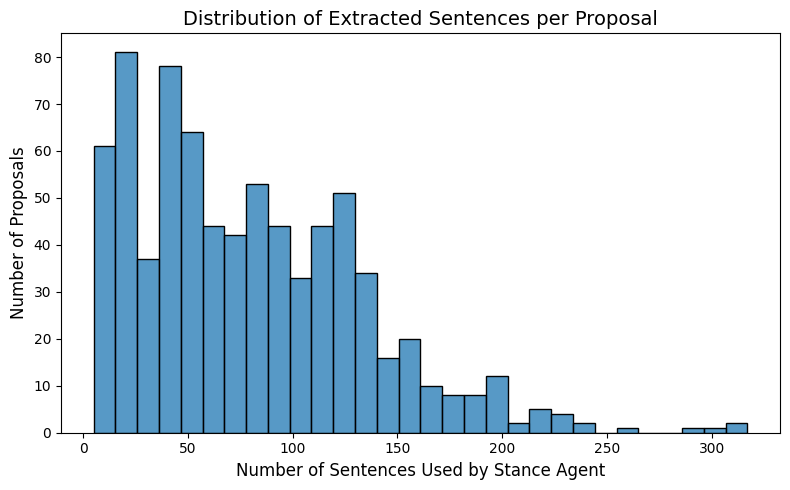

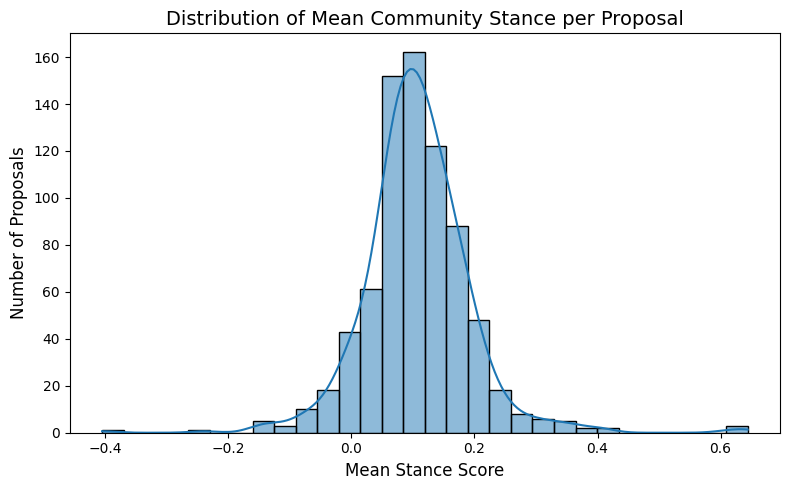

Table: Summary Statistics for Community Stance Features


,n_sents,stance_mean,stance_std,n_posts
count,758.000,758.000,758.000,758.000
mean,79.156,0.107,0.332,32.063
std,54.350,0.087,0.070,20.147
min,5.000,-0.405,0.000,1.000
25%,39.000,0.063,0.299,16.000
50%,69.000,0.105,0.334,30.000
75%,117.000,0.152,0.372,43.000
max,317.000,0.644,0.714,131.000


Table: Example Community Stance Summaries (n=5)


,proposal_id,stance_mean,stance_std,n_sents,n_pos_sents,n_neg_sents,n_neu_sents,majority_label,top_pros,top_cons,neutral_examples,n_posts
594,0xd1c48ec4d237f8abf71897226b2d9e842537fa9a8080...,0.195325,0.273748,48,16,0,32,neutral,"[""From late October to early November, GHO's d...",[],"[""Throughout the period, the ALC leveraged on ...",23
97,0x22621f3f49e99270faf063d41bc894862052f053c020...,-0.007085,0.282169,24,3,1,20,neutral,"[""Specification**: No change are required to t...","[""Tokenomics and Dilution**: - What is the pro...","[""Aave Token Holder Benefit : The acqui-hired ...",16
281,0x645981c18f5dc61c07324a39d57bcb873ebd8fb9e4a4...,0.189644,0.383030,104,32,5,67,neutral,"[""Deployment Checklist**: - Risk service provi...","[""While the supply cap sets a threshold for bo...","[""To formulate initial risk parameter recommen...",57
657,0xea2b78826c85397184f61dc9f349fdcd74447791b97c...,0.095616,0.306094,128,26,5,97,neutral,"[""wstETH E-Mode Optimism** | Risk Parameter | ...","[""WETH Utilization on ETH v3 !image #### WETH ...","[""| Risk Parameter | Current Value | Proposed ...",52
585,0xcf46924fb907fb35f15f0612fadc45dcee6f169a13dd...,0.111978,0.329889,135,27,6,102,neutral,"[""Overview** Following the successful Snapshot...","[""We support listing KNC as borrowable under r...","[""Given this, we find limited additional risk ...",50


Merged stance + outcomes: (750, 13)

=== Community Stance ↔ Outcome Correlation ===
Total proposals:      750
Passed:               688
Not Passed:           62
Mean stance (pass):   0.1075
Mean stance (not):    0.1003
Std of stance:        0.0874
Point–biserial r_pb:  0.0227
Saved point-biserial summary to: /content/drive/MyDrive/finalExperiment9/community_stance_pointbiserial_summary.csv


/tmp/ipython-input-2793932332.py:154: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


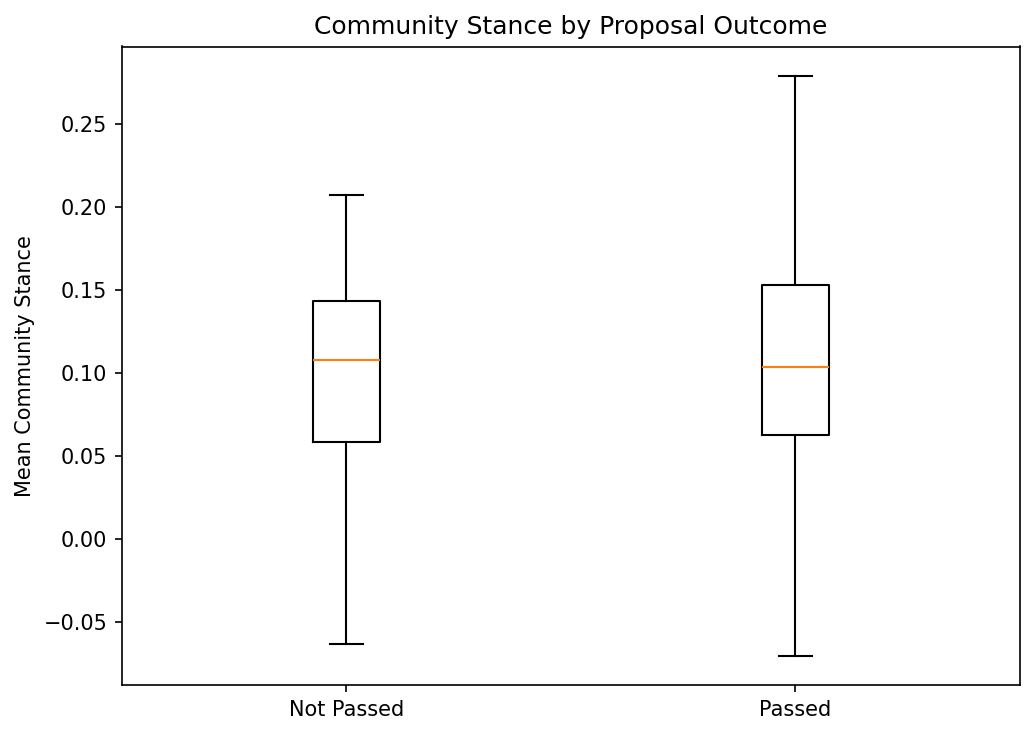

Saved stance boxplot figure to: /content/drive/MyDrive/finalExperiment9/community_stance_boxplot.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# 0) Load the aggregated community stance CSV
# ============================================================
stance_df = pd.read_csv("/content/drive/MyDrive/finalExperiment9/community_stance_per_proposal.csv")

print("Stance dataframe shape:", stance_df.shape)
display(stance_df.head())

# For clarity, think of stance_df as already "per_prop"
per_prop = stance_df.copy()

# ============================================================
# 1) Figure: Distribution of number of sentences per proposal
#     (using n_sents from the CSV)
# ============================================================

plt.figure(figsize=(8, 5))
sns.histplot(per_prop["n_sents"], bins=30, kde=False)
plt.title("Distribution of Extracted Sentences per Proposal", fontsize=14)
plt.xlabel("Number of Sentences Used by Stance Agent", fontsize=12)
plt.ylabel("Number of Proposals", fontsize=12)
plt.tight_layout()
plt.show()

# ============================================================
# 2) Figure: Distribution of mean stance per proposal
#     (using stance_mean from the CSV)
# ============================================================

plt.figure(figsize=(8, 5))
sns.histplot(per_prop["stance_mean"], bins=30, kde=True)
plt.title("Distribution of Mean Community Stance per Proposal", fontsize=14)
plt.xlabel("Mean Stance Score", fontsize=12)
plt.ylabel("Number of Proposals", fontsize=12)
plt.tight_layout()
plt.show()

# ============================================================
# 3) Table: Summary statistics for stance features
# ============================================================

summary_table = per_prop[["n_sents", "stance_mean", "stance_std", "n_posts"]].describe().round(3)
print("Table: Summary Statistics for Community Stance Features")
display(summary_table)

# ============================================================
# 4) Table: Example proposals with stance summaries (for Chapter 5)
# ============================================================

n_examples = 5  # change to 3–6 for the thesis table

example_cols = [
    "proposal_id",
    "stance_mean",
    "stance_std",
    "n_sents",
    "n_pos_sents",
    "n_neg_sents",
    "n_neu_sents",
    "majority_label",
    "top_pros",
    "top_cons",
    "neutral_examples",
    "n_posts",
]

example_rows = (
    per_prop[example_cols]
    .sample(n_examples, random_state=42)
)

print(f"Table: Example Community Stance Summaries (n={n_examples})")
display(example_rows)

# ============================================================
# 5) Point–Biserial Correlation: Community Stance vs Outcome
# ============================================================

# Ensure proposals_clean exists with label_int (0=fail, 1=abstain, 2=pass)
assert "proposals_clean" in globals(), "proposals_clean missing — run the proposal agent data-prep cell."
assert "label_int" in proposals_clean.columns, "proposals_clean must contain label_int."

# Merge stance + proposal outcome
sp = per_prop.copy()
pc = proposals_clean[["proposal_id", "label_int"]].drop_duplicates().copy()

sp["proposal_id"] = sp["proposal_id"].astype(str)
pc["proposal_id"] = pc["proposal_id"].astype(str)

merged = sp.merge(pc, on="proposal_id", how="inner")
print("Merged stance + outcomes:", merged.shape)

# Convert outcomes: pass=1, not-pass=0
merged["pass_binary"] = (merged["label_int"] == 2).astype(int)

# Extract arrays
stance_vals = merged["stance_mean"].astype(float).values
y_binary    = merged["pass_binary"].values

# Compute point–biserial correlation manually
mean_pass     = stance_vals[y_binary == 1].mean()
mean_not_pass = stance_vals[y_binary == 0].mean()
std_all       = stance_vals.std(ddof=1)

n_pass        = (y_binary == 1).sum()
n_not_pass    = (y_binary == 0).sum()
n_total       = len(merged)

r_pb = (mean_pass - mean_not_pass) * \
       ((n_pass * n_not_pass) / (n_total**2))**0.5 / std_all

print("\n=== Community Stance ↔ Outcome Correlation ===")
print(f"Total proposals:      {n_total}")
print(f"Passed:               {n_pass}")
print(f"Not Passed:           {n_not_pass}")
print(f"Mean stance (pass):   {mean_pass:.4f}")
print(f"Mean stance (not):    {mean_not_pass:.4f}")
print(f"Std of stance:        {std_all:.4f}")
print(f"Point–biserial r_pb:  {r_pb:.4f}")

# Save a summary CSV for your results section
import numpy as np
import pandas as pd
from pathlib import Path

ARTIFACTS_DIR = Path("/content/drive/MyDrive/finalExperiment9")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

summary = pd.DataFrame([{
    "n_total": n_total,
    "n_pass": n_pass,
    "n_not_pass": n_not_pass,
    "mean_stance_pass": mean_pass,
    "mean_stance_not_pass": mean_not_pass,
    "std_stance": std_all,
    "r_point_biserial": r_pb,
}])

summary_path = ARTIFACTS_DIR / "community_stance_pointbiserial_summary.csv"
summary.to_csv(summary_path, index=False)
print("Saved point-biserial summary to:", summary_path)

# ============================================================
# 6) Figure: Boxplot of stance by pass vs not-pass
# ============================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5), dpi=150)
plt.boxplot(
    [merged.loc[merged["pass_binary"] == 0, "stance_mean"],
     merged.loc[merged["pass_binary"] == 1, "stance_mean"]],
    labels=["Not Passed", "Passed"],
    showfliers=False
)
plt.ylabel("Mean Community Stance")
plt.title("Community Stance by Proposal Outcome")
plt.tight_layout()

boxplot_path = ARTIFACTS_DIR / "community_stance_boxplot.png"
plt.savefig(boxplot_path)
plt.show()

print("Saved stance boxplot figure to:", boxplot_path)


In [ ]:
# # Ensemble Combiner: Proposal Model + Community Stance
# Blends P(pass) from the proposal agent with normalized stance; compares against a learned LR combiner.
# Saves metrics and plots in ARTIFACTS_DIR.

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.metrics import (
    f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
)

# ---------- 1) Ensure inputs exist: build ens_data if missing ----------
# We need: stance_per_proposal (from the stance section), proposals_clean (title+body+label_int+text),
# tokenizer, model (trained proposal classifier), device, MAX_LEN, BATCH_SIZE.

# Ensure stance_per_proposal is loaded if not already in memory
if "stance_per_proposal" not in globals():
    stance_path = ARTIFACTS_DIR / "community_stance_per_proposal.csv"
    if stance_path.exists():
        stance_per_proposal = pd.read_csv(stance_path)
        print(f"Loaded stance_per_proposal from {stance_path}")
    else:
        raise FileNotFoundError(f"community_stance_per_proposal.csv not found at {stance_path}. Please run the Community Stance Agent cell first.")

required_globals = ["proposals_clean", "tokenizer", "model", "device", "MAX_LEN", "BATCH_SIZE"]
missing = [g for g in required_globals if g not in globals()]
assert not missing, f"Missing globals for ensemble: {missing}. Run earlier cells."

# If ens_data is not present, compute proposal model probabilities for proposals with stance
if "ens_data" not in globals():
    target_ids = stance_per_proposal["proposal_id"].astype(str).unique()
    subset = proposals_clean[proposals_clean["proposal_id"].astype(str).isin(target_ids)].copy()
    assert len(subset) > 0, "No proposals overlap between stance_per_proposal and proposals_clean."

    subset["text"] = subset["text"].fillna("")

    # Build a dataset/dataloader for inference
    ds = ProposalDataset(
        texts=subset["text"].tolist(),
        labels=subset["label_int"].tolist(),  # for reporting only
        tokenizer=tokenizer,
        max_len=MAX_LEN
    )
    dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False)

    # Inference
    model.eval()
    probs_all = []
    with torch.no_grad():
        for batch in dl:
            inputs = {
                "input_ids": batch["input_ids"].to(device),
                "attention_mask": batch["attention_mask"].to(device)
            }
            logits = model(**inputs).logits
            prob = torch.softmax(logits, dim=-1)
            probs_all.extend(prob.detach().cpu().numpy())

    pred_df = pd.DataFrame(probs_all, columns=["P_fail","P_abstain","P_pass"])
    pred_df["proposal_id"] = subset["proposal_id"].astype(str).tolist()
    pred_df["label_int"]   = subset["label_int"].astype(int).tolist()

    # Merge with stance; drop rows without stance
    ens_data = pred_df.merge(stance_per_proposal, on="proposal_id", how="inner").dropna(subset=["stance_mean"])

# For safety, ensure numeric types and expected columns
need_cols = ["P_fail","P_abstain","P_pass","stance_mean","stance_std","n_posts","label_int"]
for c in need_cols:
    if c not in ens_data.columns:
        ens_data[c] = 0.0 if c != "label_int" else 0
ens_data["label_int"] = ens_data["label_int"].astype(int)

# ---------- 2) Simple one-parameter interpolation ----------
def evaluate_ensemble(df, w, eps=0.05):
    stance_norm = (df["stance_mean"].astype(float) + 1.0) / 2.0  # map [-1,1] -> [0,1]
    score = w * df["P_pass"].astype(float) + (1.0 - w) * stance_norm
    # 3-way decision with abstain band around 0.5
    y_pred = np.where(score > 0.5 + eps, 2, np.where(score < 0.5 - eps, 0, 1)).astype(int)
    y_true = df["label_int"].astype(int).values
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    acc = accuracy_score(y_true, y_pred)
    return macro_f1, acc, y_true, y_pred

# Split (stratified) for tuning
ens_train, ens_temp = train_test_split(
    ens_data, test_size=0.40, stratify=ens_data["label_int"], random_state=RANDOM_SEED
)
ens_val, ens_test = train_test_split(
    ens_temp, test_size=0.50, stratify=ens_temp["label_int"], random_state=RANDOM_SEED
)

# --- Calibrate P_pass with Isotonic on validation ---
from sklearn.isotonic import IsotonicRegression

iso = IsotonicRegression(out_of_bounds="clip")
iso.fit(ens_val["P_pass"].values, (ens_val["label_int"]==2).astype(int).values)

for df in (ens_train, ens_val, ens_test):
    df["P_pass_cal"] = iso.transform(df["P_pass"].values)

# Use calibrated prob in your learned ensemble features
def make_X(df):
    x = df[["P_fail","P_abstain","P_pass_cal","stance_mean","stance_std","n_posts"]].copy()
    p = df[["P_fail","P_abstain","P_pass_cal"]].clip(1e-6,1-1e-6)
    x["entropy"] = -(p*np.log(p)).sum(axis=1)
    return x.fillna(0)


# Grid search w over [0,1] on validation
best = {"w": None, "eps": 0.05, "val_macro_f1": -1.0, "val_acc": 0.0}
for w in np.linspace(0, 1, 21):
    f1_val, acc_val, *_ = evaluate_ensemble(ens_val, w, eps=0.05)
    if f1_val > best["val_macro_f1"]:
        best = {"w": float(w), "eps": 0.05, "val_macro_f1": float(f1_val), "val_acc": float(acc_val)}

# Evaluate on test with best w
f1_test, acc_test, y_true_test_interp, y_pred_test_interp = evaluate_ensemble(ens_test, best["w"], best["eps"])
print("Best w:", best["w"], "| Val macro-F1:", round(best["val_macro_f1"],4), "Val acc:", round(best["val_acc"],4))
print("Test macro-F1:", round(float(f1_test),4), "Test acc:", round(float(acc_test),4))

# Save metrics
ens_metrics = {
    "best_w": best["w"],
    "val_macro_f1": best["val_macro_f1"],
    "val_acc": best["val_acc"],
    "test_macro_f1": float(f1_test),
    "test_acc": float(acc_test)
}
with open(ARTIFACTS_DIR / "ensemble_metrics.json", "w") as f:
    json.dump(ens_metrics, f, indent=2)
print("Saved:", (ARTIFACTS_DIR / "ensemble_metrics.json").resolve())

# ---------- 3) Expanded grid over (w, eps) ----------
grid = []
for w in np.linspace(0, 1, 21):
    for eps in [0.00, 0.02, 0.05, 0.08, 0.10, 0.12]:
        f1_val, acc_val, *_ = evaluate_ensemble(ens_val, w, eps)
        grid.append((float(w), float(eps), float(f1_val), float(acc_val)))
grid = sorted(grid, key=lambda x: x[2], reverse=True)
best_w, best_eps, best_f1, best_acc = grid[0]
print(f"Best grid (val): w={best_w:.2f}, eps={best_eps:.2f}, macroF1={best_f1:.4f}, acc={best_acc:.4f}")

f1_test2, acc_test2, y_true_test_interp2, y_pred_test_interp2 = evaluate_ensemble(ens_test, best_w, best_eps)
print(f"Test macro-F1={f1_test2:.4f}, acc={acc_test2:.4f}")

# Persist grid for reproducibility
grid_df = pd.DataFrame(grid, columns=["w","eps","val_macro_f1","val_acc"])
grid_df.to_csv(ARTIFACTS_DIR / "ensemble_weight_grid.csv", index=False)

# ---------- 4) Learned combiner (multinomial LR) ----------
def make_X(df):
    x = df[["P_fail","P_abstain","P_pass_cal","stance_mean","stance_std","n_posts"]].copy()
    # entropy as uncertainty feature
    p = df[["P_fail","P_abstain","P_pass_cal"]].clip(1e-6, 1-1e-6)
    x["entropy"] = -(p*np.log(p)).sum(axis=1)
    return x.fillna(0)

X_tr, y_tr = make_X(ens_train), ens_train["label_int"].astype(int)
X_va, y_va = make_X(ens_val),   ens_val["label_int"].astype(int)
X_te, y_te = make_X(ens_test),  ens_test["label_int"].astype(int)

clf = LogisticRegression(max_iter=1000, multi_class="multinomial", solver="lbfgs")
clf.fit(pd.concat([X_tr, X_va], ignore_index=True), pd.concat([y_tr, y_va], ignore_index=True))
y_hat = clf.predict(X_te)
print("Learned combiner — Test macro-F1:", round(f1_score(y_te, y_hat, average="macro"),4),
      "acc:", round(accuracy_score(y_te, y_hat),4))
print(classification_report(y_te, y_hat, digits=4))

# ---------- 5) Imbalance-aware variant (oversample 0/1) ----------
X_cols = ["P_pass_cal","P_fail","P_abstain","stance_mean","stance_std","n_posts"]
for df_ in (ens_train, ens_val, ens_test):
    for c in X_cols:
        if c not in df_:
            df_[c] = 0.0

train_major = ens_train[ens_train["label_int"]==2]
train_c0    = ens_train[ens_train["label_int"]==0]
train_c1    = ens_train[ens_train["label_int"]==1]

c0_up = resample(train_c0, replace=True,
                 n_samples=(len(train_major)//2 if len(train_c0)>0 else 0),
                 random_state=RANDOM_SEED)
c1_up = resample(train_c1, replace=True,
                 n_samples=(len(train_major)//2 if len(train_c1)>0 else 0),
                 random_state=RANDOM_SEED)

ens_train_bal = pd.concat([train_major, c0_up, c1_up], ignore_index=True)
ens_train_bal = ens_train_bal.sample(frac=1.0, random_state=RANDOM_SEED).reset_index(drop=True)

clf_bal = LogisticRegression(multi_class="multinomial", class_weight="balanced", max_iter=2000, solver="lbfgs")
clf_bal.fit(ens_train_bal[X_cols], ens_train_bal["label_int"])

val_pred  = clf_bal.predict(ens_val[X_cols])
test_pred = clf_bal.predict(ens_test[X_cols])

print("Balanced LR — Val macro-F1:", round(f1_score(ens_val["label_int"],  val_pred,  average="macro"),4))
print("Balanced LR — Test macro-F1:", round(f1_score(ens_test["label_int"], test_pred, average="macro"),4))
print(classification_report(ens_test["label_int"], test_pred, digits=4))

# ---------- 6) Plots (saved to artifacts) ----------
# Confusion matrix for the balanced LR (often best on minorities)
fig, ax = plt.subplots(figsize=(5,4), dpi=150)
ConfusionMatrixDisplay.from_predictions(
    ens_test["label_int"], test_pred,
    display_labels=["Fail","Abstain","Pass"],
    cmap="Blues",
    ax=ax
)
ax.set_title("Ensemble Confusion Matrix (Test Split)")
plt.tight_layout()
cm_path = ARTIFACTS_DIR / "ensemble_confusion_matrix.png"
plt.savefig(cm_path)
plt.close()
print("Saved:", cm_path.resolve())

# Per-class F1 bars for the balanced LR
report = classification_report(ens_test["label_int"], test_pred, output_dict=True)
classes = [0, 1, 2]
class_labels = ["Fail", "Abstain", "Pass"]
f1_scores = [report[str(i)]["f1-score"] for i in classes]
fig, ax = plt.subplots(figsize=(6,4), dpi=150)
ax.bar(class_labels, f1_scores)
ax.set_ylabel("F1-score")
ax.set_ylim(0,1)
ax.set_title("Per-class F1 — Ensemble (Balanced LR)")
for i, v in enumerate(f1_scores):
    ax.text(i, v + 0.02, f"{v:.2f}", ha="center", fontsize=9)
plt.tight_layout()
bars_path = ARTIFACTS_DIR / "ensemble_f1_per_class.png"
plt.savefig(bars_path)
plt.close()
print("Saved:", bars_path.resolve())

Best w: 0.5 | Val macro-F1: 0.4934 Val acc: 0.8733
Test macro-F1: 0.457 Test acc: 0.88
Saved: /content/drive/MyDrive/finalExperiment9/ensemble_metrics.json
Best grid (val): w=0.30, eps=0.02, macroF1=0.4975, acc=0.8867
Test macro-F1=0.4380, acc=0.9000


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: 

Learned combiner — Test macro-F1: 0.3193 acc: 0.9133
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        10
           1     0.0000    0.0000    0.0000         3
           2     0.9195    1.0000    0.9580       137

    accuracy                         0.9133       150
   macro avg     0.3065    0.3333    0.3193       150
weighted avg     0.8398    0.9133    0.8750       150

Balanced LR — Val macro-F1: 0.4856
Balanced LR — Test macro-F1: 0.4651
              precision    recall  f1-score   support

           0     0.1579    0.3000    0.2069        10
           1     0.1818    0.6667    0.2857         3
           2     0.9667    0.8467    0.9027       137

    accuracy                         0.8067       150
   macro avg     0.4355    0.6045    0.4651       150
weighted avg     0.8971    0.8067    0.8440       150

Saved: /content/drive/MyDrive/finalExperiment9/ensemble_confusion_matrix.png
Saved: /content/drive/MyDrive/finalEx

In [ ]:
# # Ablations, Calibration, Audit, and Exports (Aligned Artifacts)

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score, accuracy_score, classification_report, brier_score_loss, roc_auc_score
)
from sklearn.calibration import calibration_curve
from sklearn.utils import resample
import torch
from torch.utils.data import DataLoader

# --- Config & guards ---
ARTIFACTS_DIR = Path("/content/drive/MyDrive/finalExperiment9")


from sklearn.model_selection import train_test_split

# --- Make sure proposals_clean and stance_per_proposal exist ---
base_need = ["proposals_clean", "stance_per_proposal"]
base_missing = [n for n in base_need if n not in globals()]
assert not base_missing, f"Missing base variables: {base_missing} (run the earlier data-prep cells)"

# --- If we don't have train/val/test splits yet, build them from ens_data ---
if not all(k in globals() for k in ["ens_train", "ens_val", "ens_test"]):
    assert "ens_data" in globals(), "ens_data missing; run the ensemble-combiner cell that builds ens_data."

    X_cols_all = ["P_pass","P_fail","P_abstain","stance_mean","stance_std","n_posts"]

    # ensure_cols is defined later in your cell; do a local version here for safety
    def ensure_cols(df, cols):
        out = df.copy()
        for c in cols:
            if c not in out.columns:
                out[c] = 0.0
        return out

    ens_data_local = ensure_cols(ens_data, X_cols_all)

    ens_train, temp = train_test_split(
        ens_data_local,
        test_size=0.4,
        stratify=ens_data_local["label_int"],
        random_state=42,
    )
    ens_val, ens_test = train_test_split(
        temp,
        test_size=0.5,
        stratify=temp["label_int"],
        random_state=42,
    )

    print("Recreated ens_train / ens_val / ens_test from ens_data:")
    print("  ens_train:", ens_train.shape, "ens_val:", ens_val.shape, "ens_test:", ens_test.shape)

# At this point these should all exist
need = ["ens_train","ens_val","ens_test","proposals_clean","stance_per_proposal"]
miss = [n for n in need if n not in globals()]
assert not miss, f"Missing variables for analysis: {miss}"


# Ensure required columns (non-destructive: work on copies for safety)
def ensure_cols(df, cols):
    out = df.copy()
    for c in cols:
        if c not in out.columns:
            out[c] = 0.0
    return out

X_cols_all = ["P_pass","P_fail","P_abstain","stance_mean","stance_std","n_posts"]
ens_train = ensure_cols(ens_train, X_cols_all)
ens_val   = ensure_cols(ens_val,   X_cols_all)
ens_test  = ensure_cols(ens_test,  X_cols_all)

# ---------- 1) ABLATION: proposal-only, stance-only, ensemble ----------
def predict_3way_from_binary(clf, X, eps=0.05):
    """Convert binary pass-vs-not probs to 3-way with an abstain band around 0.5."""
    p = clf.predict_proba(X)[:,1]
    y3 = np.where(p > 0.5 + eps, 2, np.where(p < 0.5 - eps, 0, 1)).astype(int)
    return y3, p

def ablation_binary(train_df, val_df, test_df, X_cols, y_col="label_int", eps=0.05):
    # Build binary labels once
    for df in (train_df, val_df, test_df):
        df["y_bin"] = (df[y_col] == 2).astype(int)
    clf = LogisticRegression(class_weight="balanced", max_iter=1000, solver="lbfgs")
    clf.fit(train_df[X_cols], train_df["y_bin"])
    val_y3, val_prob = predict_3way_from_binary(clf, val_df[X_cols], eps)
    test_y3, test_prob = predict_3way_from_binary(clf, test_df[X_cols], eps)
    val_f1 = f1_score(val_df[y_col],  val_y3, average="macro")
    test_f1 = f1_score(test_df[y_col], test_y3, average="macro")
    auc_val = roc_auc_score(val_df["y_bin"], val_prob)
    auc_test = roc_auc_score(test_df["y_bin"], test_prob)
    return clf, val_f1, test_f1, auc_val, auc_test, test_y3

# Proposal-only (softmax probs)
Xp_cols = ["P_pass","P_fail","P_abstain"]
clf_prop, val_f1_prop, test_f1_prop, aucv_prop, auct_prop, test_pred_prop = ablation_binary(
    ens_train.copy(), ens_val.copy(), ens_test.copy(), X_cols=Xp_cols, eps=0.05
)

# Stance-only (stance_mean only)
clf_st, val_f1_st, test_f1_st, aucv_st, auct_st, test_pred_st = ablation_binary(
    ens_train.copy(), ens_val.copy(), ens_test.copy(), X_cols=["stance_mean"], eps=0.05
)

# Ensemble (multinomial) — reuse if already fit; else fit here quickly
if "clf_ens" not in globals():
    clf_ens = LogisticRegression(multi_class="multinomial", class_weight="balanced", max_iter=2000, solver="lbfgs")
    clf_ens.fit(ens_train[X_cols_all], ens_train["label_int"])
ens_val_pred  = clf_ens.predict(ens_val[X_cols_all])
ens_test_pred = clf_ens.predict(ens_test[X_cols_all])

val_f1_ens  = f1_score(ens_val["label_int"],  ens_val_pred,  average="macro")
test_f1_ens = f1_score(ens_test["label_int"], ens_test_pred, average="macro")

ablation = pd.DataFrame({
    "Model": ["Proposal-only (bin→3way)", "Stance-only (bin→3way)", "Ensemble (multinomial)"],
    "Val Macro-F1": [val_f1_prop, val_f1_st, val_f1_ens],
    "Test Macro-F1": [test_f1_prop, test_f1_st, test_f1_ens],
    "Val AUC (bin)": [aucv_prop, aucv_st, np.nan],
    "Test AUC (bin)": [auct_prop, auct_st, np.nan],
})
ablation_path = ARTIFACTS_DIR / "ablation_results.csv"
ablation.to_csv(ablation_path, index=False)
print("Saved:", ablation_path)

# ---------- 2) CALIBRATION: reliability curves, ECE, Brier ----------
def expected_calibration_error(y_true, y_prob, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        mask = (y_prob >= lo) & (y_prob < hi) if i < n_bins-1 else (y_prob >= lo) & (y_prob <= hi)
        if mask.any():
            conf = y_prob[mask].mean()
            acc  = y_true[mask].mean()
            ece += (mask.sum() / len(y_true)) * abs(acc - conf)
    return ece

# Build binary labels: pass vs not
for df in (ens_val, ens_test):
    df["y_bin"] = (df["label_int"] == 2).astype(int)

prop_val_prob  = ens_val["P_pass"].values
prop_test_prob = ens_test["P_pass"].values
y_val_bin  = ens_val["y_bin"].values
y_test_bin = ens_test["y_bin"].values

proba_val_ens  = clf_ens.predict_proba(ens_val[X_cols_all])[:, list(clf_ens.classes_).index(2)]
proba_test_ens = clf_ens.predict_proba(ens_test[X_cols_all])[:, list(clf_ens.classes_).index(2)]

rows = []
for name, probs, ybin in [
    ("proposal_val", prop_val_prob, y_val_bin),
    ("proposal_test", prop_test_prob, y_test_bin),
    ("ensemble_val", proba_val_ens, y_val_bin),
    ("ensemble_test", proba_test_ens, y_test_bin),
]:
    rows.append({
        "series": name,
        "ece": float(expected_calibration_error(ybin, probs, n_bins=10)),
        "brier": float(brier_score_loss(ybin, probs))
    })
calib_tbl = pd.DataFrame(rows)
calib_tbl_path = ARTIFACTS_DIR / "calibration_metrics.csv"
calib_tbl.to_csv(calib_tbl_path, index=False)
print("Saved:", calib_tbl_path)

def save_reliability(y_true, y_prob, title, out_path):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy="uniform")
    plt.figure(figsize=(5,5), dpi=150)
    plt.plot(prob_pred, prob_true, marker="o", label="Empirical")
    plt.plot([0,1],[0,1], "--", color="gray", label="Perfect")
    plt.xlabel("Predicted probability")
    plt.ylabel("Empirical pass rate")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_path)
    plt.close()

save_reliability(y_val_bin,  prop_val_prob,  "Calibration: Proposal P(pass) [Val]",  ARTIFACTS_DIR / "calib_proposal_val.png")
save_reliability(y_test_bin, prop_test_prob, "Calibration: Proposal P(pass) [Test]", ARTIFACTS_DIR / "calib_proposal_test.png")
save_reliability(y_val_bin,  proba_val_ens,  "Calibration: Ensemble P(pass) [Val]",  ARTIFACTS_DIR / "calib_ensemble_val.png")
save_reliability(y_test_bin, proba_test_ens, "Calibration: Ensemble P(pass) [Test]", ARTIFACTS_DIR / "calib_ensemble_test.png")
print("Saved calibration plots to:", ARTIFACTS_DIR)

# ---------- 3) MISCLASSIFIED CASE AUDIT (using ensemble multinomial) ----------
test_df = ens_test.copy()
test_df["y_true"] = test_df["label_int"].astype(int)
test_df["y_pred"] = ens_test_pred.astype(int)

proba_test_all = clf_ens.predict_proba(ens_test[X_cols_all])
pred_idx = [list(clf_ens.classes_).index(c) for c in test_df["y_pred"]]
test_df["pred_conf"] = [proba_test_all[i, idx] for i, idx in enumerate(pred_idx)]

# --- Build proposals frame with only columns that actually exist ---
base_cols = ["proposal_id"]
for c in ["title", "body"]:
    if c in proposals_clean.columns:
        base_cols.append(c)

print("Using these proposal columns for audit:", base_cols)

pc = proposals_clean[base_cols].copy()
pc["proposal_id"] = pc["proposal_id"].astype(str)
test_df["proposal_id"] = test_df["proposal_id"].astype(str)

audit = test_df.merge(pc, on="proposal_id", how="left")
audit = audit[audit["y_true"] != audit["y_pred"]].copy().sort_values("pred_conf", ascending=False)

def snip(x, n=160):
    x = (x or "")
    return (x[:n] + "…") if len(x) > n else x

# Start with core numeric columns
cols = ["proposal_id", "y_true", "y_pred", "pred_conf", "P_pass", "stance_mean", "n_posts"]

# Only add snippets if the columns exist after merge
if "title" in audit.columns:
    audit["title_snippet"] = audit["title"].astype(str).apply(lambda x: snip(x, 120))
    cols.append("title_snippet")

if "body" in audit.columns:
    audit["body_snippet"] = audit["body"].astype(str).apply(lambda x: snip(x, 180))
    cols.append("body_snippet")

audit_view = audit[cols]

audit_path = ARTIFACTS_DIR / "ensemble_misclass_top.csv"
audit_view.to_csv(audit_path, index=False)
print("Saved:", audit_path)


# ---------- 4) OPTIONAL: Embedding UMAP (sampled for speed) ----------
try:
    import umap
    SUBN = min(400, len(ens_test))
    subset = ens_test.sample(SUBN, random_state=42).merge(
        proposals_clean[["proposal_id","title","body"]], on="proposal_id", how="left"
    )
    subset["text"] = subset.apply(lambda r: re.sub(r"\s+"," ", f"{r.get('title','')}\n\n{r.get('body','')}").strip(), axis=1)

    class TinyDS(torch.utils.data.Dataset):
        def __init__(self, texts, tokenizer, max_len):
            self.texts = texts; self.tok = tokenizer; self.max_len = max_len
        def __len__(self): return len(self.texts)
        def __getitem__(self, i):
            enc = self.tok(self.texts[i], truncation=True, padding="max_length", max_length=self.max_len, return_tensors="pt")
            return {k: v.squeeze(0) for k,v in enc.items()}

    ds = TinyDS(subset["text"].tolist(), tokenizer, MAX_LEN)
    dl = DataLoader(ds, batch_size=32, shuffle=False)
    model.eval()

    embs = []
    with torch.no_grad():
        for batch in dl:
            batch = {k: v.to(device) for k,v in batch.items()}
            # DistilBERT: last_hidden_state
            hidden = model.base_model(**batch)[0]  # [B, T, H]
            cls = hidden[:,0,:].detach().cpu().numpy()
            embs.append(cls)
    embs = np.concatenate(embs, axis=0)

    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="cosine", random_state=42)
    u = reducer.fit_transform(embs)

    colors = {0:"tomato", 1:"gold", 2:"skyblue"}
    labels = subset["label_int"].astype(int).values
    plt.figure(figsize=(6,5), dpi=150)
    for c in [0,1,2]:
        mask = labels == c
        plt.scatter(u[mask,0], u[mask,1], s=12, alpha=0.7, c=colors[c], label={0:"Fail",1:"Abstain",2:"Pass"}[c])
    plt.legend()
    plt.title("Proposal Embeddings (UMAP) by Outcome — Sampled")
    plt.tight_layout()
    embs_path = ARTIFACTS_DIR / "embeddings_umap.png"
    plt.savefig(embs_path)
    plt.close()
    print("Saved:", embs_path)
except Exception as e:
    print("UMAP skipped:", e)

# ---------- 5) Deterministic Exports for the Explainer ----------
# (A) Proposal agent minimal JSONL (action-type heuristics; risk placeholders)
OUT = ARTIFACTS_DIR / "proposal_agent_results.jsonl"
def infer_action_type(title, body):
    t = f"{str(title)}\n{str(body)}".lower()
    if any(k in t for k in ["ltv","liquidation threshold","reserve factor","borrow cap","supply cap","e-mode","isolation"]):
        return "parameter_change"
    if any(k in t for k in ["add asset","list asset","onboard","new listing"]):
        return "asset_listing"
    if any(k in t for k in ["deploy aave v3 on","deploy on","new chain","rollup","zk","l2","starknet","arbitrum","optimism","base","linea","zksync"]):
        return "deployment"
    if any(k in t for k in ["grant","fund","budget","service provider","treasury"]):
        return "treasury_grant"
    return "other"

pclean = proposals_clean.fillna("")
with open(OUT, "w", encoding="utf-8") as f:
    for _, r in pclean.iterrows():
        rec = {
            "proposal_id": str(r["proposal_id"]),
            "title": str(r.get("title","")),
            "action_type": infer_action_type(r.get("title",""), r.get("body","")),
            "risk_scores": {"market": 0.0, "liquidity": 0.0, "smart_contract": 0.0, "governance": 0.0},
            "risk_flags": [],
            "treasury_impact": "unknown",
        }
        f.write(json.dumps(rec, ensure_ascii=False) + "\n")
print("Saved:", OUT)

# (B) Ensemble decisions JSONL — use aave_pred + keep all stance proposals
# (B) Ensemble decisions JSONL — minimal + full version with metadata
OUT_MIN  = ARTIFACTS_DIR / "ensemble_decisions.jsonl"
OUT_FULL = ARTIFACTS_DIR / "ensemble_decisions_full.jsonl"

# Keep stance features so we can write them out
base = stance_per_proposal[["proposal_id", "stance_mean", "stance_std", "n_posts"]].drop_duplicates().copy()
base["proposal_id"] = base["proposal_id"].astype(str)

# Use aave_pred if present, else ens_data
source_df = aave_pred if "aave_pred" in globals() else ens_data
pred = source_df[["proposal_id","P_fail","P_abstain","P_pass"]].copy()
pred["proposal_id"] = pred["proposal_id"].astype(str)

# Resolve probability columns robustly
def resolve_cols(df):
    colmap = {c.lower(): c for c in df.columns}
    need = {"p_fail": None, "p_abstain": None, "p_pass": None}
    for k, orig in [("p_fail","P_fail"), ("p_abstain","P_abstain"), ("p_pass","P_pass")]:
        if orig in df.columns:
            need[k] = orig
    for k in list(need.keys()):
        if need[k] is None and k in colmap:
            need[k] = colmap[k]
    aliases = {
        "p_fail":    ["prob_fail","fail_prob"],
        "p_abstain": ["prob_abstain","abstain_prob","p_hold","prob_hold"],
        "p_pass":    ["prob_pass","pass_prob","prob_yes","p_yes"],
    }
    for k, alts in aliases.items():
        if need[k] is None:
            for a in alts:
                if a in colmap:
                    need[k] = colmap[a]
                    break
    return need

need = resolve_cols(pred)
missing = [k for k,v in need.items() if v is None]
assert not missing, f"Missing probability columns {missing} in ensemble source."

prob_cols = [need["p_fail"], need["p_abstain"], need["p_pass"]]
prob_pp = pred.groupby("proposal_id")[prob_cols].mean().reset_index()
joined = base.merge(prob_pp, on="proposal_id", how="left")

def decide_row(row):
    vals = [row[prob_cols[0]], row[prob_cols[1]], row[prob_cols[2]]]
    if any(pd.isna(v) for v in vals):
        return "ABSTAIN"
    idx = int(np.argmax(vals))
    return {0: "NO", 1: "ABSTAIN", 2: "YES"}[idx]

def drivers_row(row):
    vals = [row.get(prob_cols[0]), row.get(prob_cols[1]), row.get(prob_cols[2])]
    if any(pd.isna(v) for v in vals):
        return ["insufficient_predictions"]
    top = max(vals)
    second = sorted(vals)[-2]
    return ["community_split"] if (top - second) < 0.05 else ["confidence_thresholding"]

def weights_row():
    """
    Use the global interpolation weight from the ensemble combiner:
      score = w * P_pass + (1-w) * stance_norm
    If best_w isn't in scope for some reason, return empty dict.
    """
    try:
        w = float(best_w)
        # Only numeric agent weights – no rule string
        return {
            "proposal_agent": w,
            "community_stance_agent": 1.0 - w,
        }
    except Exception:
        return {}


import pandas as pd
import math

def safe_float(x):
    try:
        return float(x) if pd.notna(x) else None
    except Exception:
        return None

def safe_int(x):
    try:
        return int(x) if pd.notna(x) else None
    except Exception:
        return None

with open(OUT_MIN, "w", encoding="utf-8") as f_min, \
     open(OUT_FULL, "w", encoding="utf-8") as f_full:
    for _, r in joined.iterrows():
        final_vote = decide_row(r)
        drivers = drivers_row(r)

        # Base record (backwards compatible)
        rec_min = {
            "proposal_id": str(r["proposal_id"]),
            "final_vote": final_vote,
            "drivers": drivers,
        }
        f_min.write(json.dumps(rec_min) + "\n")

        # Enriched record for explainer
        rec_full = {
            **rec_min,
            # raw probabilities
            "P_fail":    safe_float(r.get(prob_cols[0])),
            "P_abstain": safe_float(r.get(prob_cols[1])),
            "P_pass":    safe_float(r.get(prob_cols[2])),
            # stance metadata (if available)
            "stance_mean": safe_float(r.get("stance_mean")),
            "stance_std":  safe_float(r.get("stance_std")),
            "n_posts":     safe_int(r.get("n_posts")),
            # coarse mixture weights between agents
            "weights_used": weights_row(),
        }

        stance_norm = None
        if rec_full["P_pass"] is not None and rec_full["stance_mean"] is not None:
            stance_norm = (rec_full["stance_mean"] + 1.0) / 2.0
            w = rec_full["weights_used"].get("proposal_agent", 0.5)
            rec_full["ensemble_score_interp"] = w * rec_full["P_pass"] + (1.0 - w) * stance_norm
        else:
            rec_full["ensemble_score_interp"] = None

        f_full.write(json.dumps(rec_full, ensure_ascii=False) + "\n")

print("Saved:", OUT_MIN)
print("Saved:", OUT_FULL)


# (C) Community stance JSONL for explainer
SRC = ARTIFACTS_DIR / "community_stance_per_proposal.csv"
OUT = ARTIFACTS_DIR / "community_stance_results.jsonl"
df = pd.read_csv(SRC)
df["proposal_id"] = df["proposal_id"].astype(str)
assert "stance_mean" in df.columns, "stance_mean missing from stance CSV."

def to_triplet(score):
    pos = max(0.0, min(1.0, (score + 1) / 2))
    neg = max(0.0, min(1.0, (1 - score) / 2))
    neu = max(0.0, 1.0 - abs(score)) * 0.5
    s = pos + neu + neg
    if s == 0: return 0.33, 0.34, 0.33
    return pos/s, neu/s, neg/s

with open(OUT, "w", encoding="utf-8") as f:
    for _, r in df.iterrows():
        sc = float(r["stance_mean"])
        pos, neu, neg = to_triplet(sc)
        tone = "supportive" if sc > 0.2 else ("skeptical" if sc < -0.2 else "mixed")
        f.write(json.dumps({
            "proposal_id": str(r["proposal_id"]),
            "stance_scores": {"pos": round(pos,3), "neu": round(neu,3), "neg": round(neg,3)},
            "tone_label": tone,
            "salient_arguments": {"pro": [], "con": []},
            "influential_posts": []
        }, ensure_ascii=False) + "\n")
print("Saved:", OUT)



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Saved: /content/drive/MyDrive/finalExperiment9/ablation_results.csv
Saved: /content/drive/MyDrive/finalExperiment9/calibration_metrics.csv
Saved calibration plots to: /content/drive/MyDrive/finalExperiment9
Using these proposal columns for audit: ['proposal_id', 'title', 'body']
Saved: /content/drive/MyDrive/finalExperiment9/ensemble_misclass_top.csv


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved: /content/drive/MyDrive/finalExperiment9/embeddings_umap.png
Saved: /content/drive/MyDrive/finalExperiment9/proposal_agent_results.jsonl
Saved: /content/drive/MyDrive/finalExperiment9/ensemble_decisions.jsonl
Saved: /content/drive/MyDrive/finalExperiment9/ensemble_decisions_full.jsonl
Saved: /content/drive/MyDrive/finalExperiment9/community_stance_results.jsonl


In [ ]:
# === Ensemble (Balanced Logistic Regression) – Figures & Tables ===
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    f1_score,
    accuracy_score
)

# -------------------------------------------------------------------
# Config / assumptions
# -------------------------------------------------------------------
ARTIFACTS_DIR = Path("/content/drive/MyDrive/finalExperiment9")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

# Columns used by the ensemble combiner
X_cols_all = ["P_pass", "P_fail", "P_abstain", "stance_mean", "stance_std", "n_posts"]

id2label_ens = {0: "fail", 1: "abstain", 2: "pass"}

# -------------------------------------------------------------------
# 1) Ensure columns exist and fit balanced LR combiner
# -------------------------------------------------------------------
def ensure_cols(df, cols):
    out = df.copy()
    for c in cols:
        if c not in out.columns:
            out[c] = 0.0
    return out

ens_train_bal = ensure_cols(ens_train, X_cols_all)
ens_val_bal   = ensure_cols(ens_val,   X_cols_all)
ens_test_bal  = ensure_cols(ens_test,  X_cols_all)

y_train = ens_train_bal["label_int"].astype(int).values
y_val   = ens_val_bal["label_int"].astype(int).values
y_test  = ens_test_bal["label_int"].astype(int).values

clf_bal = LogisticRegression(
    multi_class="multinomial",
    class_weight="balanced",
    max_iter=2000,
    solver="lbfgs",
    n_jobs=-1,
    random_state=42,
)
clf_bal.fit(ens_train_bal[X_cols_all], y_train)

# Validation + test macro-F1 / accuracy (for sanity)
val_pred_bal = clf_bal.predict(ens_val_bal[X_cols_all])
test_pred_bal = clf_bal.predict(ens_test_bal[X_cols_all])

val_macro_f1_bal = f1_score(y_val, val_pred_bal, average="macro")
test_macro_f1_bal = f1_score(y_test, test_pred_bal, average="macro")
test_acc_bal = accuracy_score(y_test, test_pred_bal)

print(f"Balanced LR — Val macro-F1: {val_macro_f1_bal:.4f}")
print(f"Balanced LR — Test macro-F1: {test_macro_f1_bal:.4f}, Test acc: {test_acc_bal:.4f}")

# -------------------------------------------------------------------
# 2) Learned weights for proposal vs community features
#    (coefficients for each class)
# -------------------------------------------------------------------
coef_df = pd.DataFrame(clf_bal.coef_, columns=X_cols_all)
coef_df["class"] = [id2label_ens[i] for i in range(coef_df.shape[0])]
coef_cols = ["class"] + X_cols_all
coef_df = coef_df[coef_cols]

coef_path = ARTIFACTS_DIR / "ensemble_balanced_coefficients.csv"
coef_df.to_csv(coef_path, index=False)
print("Saved coefficients table:", coef_path)

# For a simple “agent weight” view, extract class=pass coefficients for P_pass vs stance_mean
pass_row = coef_df[coef_df["class"] == "pass"].iloc[0]
agent_weights_df = pd.DataFrame({
    "Agent": ["proposal_agent", "community_stance_agent"],
    "Feature": ["P_pass", "stance_mean"],
    "Coefficient_class_pass": [pass_row["P_pass"], pass_row["stance_mean"]],
})
agent_weights_path = ARTIFACTS_DIR / "ensemble_balanced_agent_weights.csv"
agent_weights_df.to_csv(agent_weights_path, index=False)
print("Saved agent weights table:", agent_weights_path)

# -------------------------------------------------------------------
# 3) Confusion matrix figure for ensemble (balanced LR)
# -------------------------------------------------------------------
cm = confusion_matrix(y_test, test_pred_bal, labels=[0, 1, 2])

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm, interpolation="nearest")
ax.set_title("Ensemble (Balanced LR) — Confusion Matrix (Test)")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_xticks([0, 1, 2])
ax.set_yticks([0, 1, 2])
ax.set_xticklabels([id2label_ens[i] for i in [0, 1, 2]])
ax.set_yticklabels([id2label_ens[i] for i in [0, 1, 2]])

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
cm_path = ARTIFACTS_DIR / "ensemble_balanced_confusion_matrix.png"
plt.savefig(cm_path, dpi=150)
plt.close(fig)
print("Saved confusion matrix figure:", cm_path)

# -------------------------------------------------------------------
# 4) Per-class precision / recall / F1 table for ensemble (balanced LR)
# -------------------------------------------------------------------
report_dict = classification_report(
    y_test,
    test_pred_bal,
    digits=4,
    target_names=[id2label_ens[i] for i in [0, 1, 2]],
    output_dict=True,
)

report_df = pd.DataFrame(report_dict).transpose()
cls_report_path = ARTIFACTS_DIR / "ensemble_balanced_classification_report.csv"
report_df.to_csv(cls_report_path, index=True)
print("Saved classification report table:", cls_report_path)

# -------------------------------------------------------------------
# 5) Comparison table: Proposal agent vs Ensemble (balanced LR)
# -------------------------------------------------------------------
# Load proposal agent metrics (must have been saved earlier)
prop_metrics_path = ARTIFACTS_DIR / "proposal_outcome_metrics.json"
with open(prop_metrics_path, "r") as f:
    prop_metrics = json.load(f)

ensemble_metrics = {
    "test_acc": float(test_acc_bal),
    "test_macro_f1": float(test_macro_f1_bal),
}

# Save ensemble metrics to JSON as well (optional)
ens_metrics_path = ARTIFACTS_DIR / "ensemble_balanced_metrics.json"
with open(ens_metrics_path, "w") as f:
    json.dump(ensemble_metrics, f, indent=2)
print("Saved ensemble metrics:", ens_metrics_path)

# Build comparison table
comp_df = pd.DataFrame([
    {
        "Model": "Proposal Agent (DistilBERT)",
        "Test Accuracy": prop_metrics.get("test_acc", np.nan),
        "Test Macro-F1": prop_metrics.get("test_macro_f1", np.nan),
    },
    {
        "Model": "Ensemble (Balanced LR)",
        "Test Accuracy": ensemble_metrics["test_acc"],
        "Test Macro-F1": ensemble_metrics["test_macro_f1"],
    },
])

comp_path = ARTIFACTS_DIR / "proposal_vs_ensemble_metrics.csv"
comp_df.to_csv(comp_path, index=False)
print("Saved comparison table:", comp_path)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Balanced LR — Val macro-F1: 0.6327
Balanced LR — Test macro-F1: 0.4747, Test acc: 0.8067
Saved coefficients table: /content/drive/MyDrive/finalExperiment9/ensemble_balanced_coefficients.csv
Saved agent weights table: /content/drive/MyDrive/finalExperiment9/ensemble_balanced_agent_weights.csv
Saved confusion matrix figure: /content/drive/MyDrive/finalExperiment9/ensemble_balanced_confusion_matrix.png
Saved classification report table: /content/drive/MyDrive/finalExperiment9/ensemble_balanced_classification_report.csv
Saved ensemble metrics: /content/drive/MyDrive/finalExperiment9/ensemble_balanced_metrics.json
Saved comparison table: /content/drive/MyDrive/finalExperiment9/proposal_vs_ensemble_metrics.csv


In [ ]:
for name in ["proposals_clean", "stance_per_proposal", "ens_data", "ens_train", "ens_val", "ens_test"]:
    print(name, "->", name in globals())


proposals_clean -> True
stance_per_proposal -> True
ens_data -> False
ens_train -> False
ens_val -> False
ens_test -> False


In [ ]:
# === Unified Ensemble Results (Mixture: 25% Proposal, 75% Community) ===
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
    brier_score_loss,
)
from sklearn.calibration import calibration_curve

ARTIFACTS_DIR = Path("/content/drive/MyDrive/finalExperiment9")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)



# ---------------------------------------------------------------------
# 1) Ensure we have ens_train / ens_val / ens_test
#    If not, derive them from ens_data (single source of truth)
# ---------------------------------------------------------------------
need_base = ["ens_data"]
missing_base = [n for n in need_base if n not in globals()]
assert not missing_base, f"Missing {missing_base}. Run the ensemble combiner cell that builds ens_data."

X_cols_all = ["P_pass", "P_fail", "P_abstain", "stance_mean", "stance_std", "n_posts"]

def ensure_cols(df, cols):
    out = df.copy()
    for c in cols:
        if c not in out.columns:
            out[c] = 0.0
    return out

if not all(k in globals() for k in ["ens_train", "ens_val", "ens_test"]):
    print("ens_train/ens_val/ens_test not found; recreating splits from ens_data.")
    ens_data_local = ensure_cols(ens_data, X_cols_all)
    # Stratified split on label_int
    train_df, temp_df = train_test_split(
        ens_data_local,
        test_size=0.40,
        stratify=ens_data_local["label_int"],
        random_state=42,
    )
    val_df, test_df = train_test_split(
        temp_df,
        test_size=0.50,
        stratify=temp_df["label_int"],
        random_state=42,
    )
    ens_train, ens_val, ens_test = train_df, val_df, test_df

ens_train = ensure_cols(ens_train, X_cols_all)
ens_val   = ensure_cols(ens_val,   X_cols_all)
ens_test  = ensure_cols(ens_test,  X_cols_all)

print("Split sizes (train / val / test):", len(ens_train), len(ens_val), len(ens_test))

# Mixture configuration (set from grid search)
W_PROPOSAL = best_w
W_STANCE   = 1.0 - best_w
EPS        = best_eps

print(f"Unified ensemble configuration (from grid search): "
      f"w={W_PROPOSAL:.2f} (proposal), 1-w={W_STANCE:.2f} (community), eps={EPS:.2f}")


# ---------------------------------------------------------------------
# 2) Mixture ensemble: score + 3-way decision
# ---------------------------------------------------------------------
def mixture_scores_and_preds(df, w=W_PROPOSAL, eps=EPS):
    """
    df: DataFrame with columns P_pass, stance_norm, label_int
    Returns:
        mix_score: continuous mixture probability of "pass"
        y_pred:   3-way predictions (0=fail, 1=abstain, 2=pass)
    """
    stance_norm = df["stance_norm"].astype(float).values
    p_pass = df["P_pass"].astype(float).values

    mix_score = w * p_pass + (1.0 - w) * stance_norm

    y_pred = np.where(
        mix_score > 0.5 + eps, 2,
        np.where(mix_score < 0.5 - eps, 0, 1)
    ).astype(int)

    return mix_score, y_pred


# True labels
y_val   = ens_val["label_int"].astype(int).values
y_test  = ens_test["label_int"].astype(int).values

mix_val_score,  mix_val_pred  = mixture_scores_and_preds(ens_val)
mix_test_score, mix_test_pred = mixture_scores_and_preds(ens_test)

# Metrics
val_macro_f1  = f1_score(y_val,  mix_val_pred,  average="macro")
val_acc       = accuracy_score(y_val,  mix_val_pred)
test_macro_f1 = f1_score(y_test, mix_test_pred, average="macro")
test_acc      = accuracy_score(y_test, mix_test_pred)

print(f"Mixture ensemble (w={W_PROPOSAL}, eps={EPS}) — Val macro-F1: {val_macro_f1:.4f}, Val acc: {val_acc:.4f}")
print(f"Mixture ensemble (w={W_PROPOSAL}, eps={EPS}) — Test macro-F1: {test_macro_f1:.4f}, Test acc: {test_acc:.4f}")

print("Class counts test:", np.bincount(ens_test["label_int"].astype(int)))
print("Pred counts test:", np.bincount(mix_test_pred))
print(classification_report(y_test, mix_test_pred, digits=4, target_names=[id2label[i] for i in [0,1,2]]))


# ---------------------------------------------------------------------
# 3) Confusion matrix figure (test)
# ---------------------------------------------------------------------
id2label = {0: "fail", 1: "abstain", 2: "pass"}

cm = confusion_matrix(y_test, mix_test_pred, labels=[0, 1, 2])
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm, interpolation="nearest")
ax.set_title("Ensemble (Mixture) — Confusion Matrix (Test)")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_xticks([0, 1, 2])
ax.set_yticks([0, 1, 2])
ax.set_xticklabels([id2label[i] for i in [0, 1, 2]])
ax.set_yticklabels([id2label[i] for i in [0, 1, 2]])

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
cm_path = ARTIFACTS_DIR / "ensemble_mixture_confusion_matrix.png"
plt.savefig(cm_path, dpi=150)
plt.close(fig)
print("Saved confusion matrix figure:", cm_path)

# ---------------------------------------------------------------------
# 4) Per-class precision/recall/F1 table for ensemble (test)
# ---------------------------------------------------------------------
report_dict = classification_report(
    y_test,
    mix_test_pred,
    digits=4,
    target_names=[id2label[i] for i in [0, 1, 2]],
    output_dict=True,
)
report_df = pd.DataFrame(report_dict).transpose()
report_path = ARTIFACTS_DIR / "ensemble_mixture_classification_report.csv"
report_df.to_csv(report_path, index=True)
print("Saved ensemble classification report table:", report_path)

# ---------------------------------------------------------------------
# 5) Calibration metrics: proposal vs ensemble (binary pass vs not)
# ---------------------------------------------------------------------
def expected_calibration_error(y_true, y_prob, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        if i < n_bins - 1:
            mask = (y_prob >= lo) & (y_prob < hi)
        else:
            mask = (y_prob >= lo) & (y_prob <= hi)
        if mask.any():
            conf = y_prob[mask].mean()
            acc  = y_true[mask].mean()
            ece += (mask.sum() / len(y_true)) * abs(acc - conf)
    return ece

# Binary labels: pass vs not-pass
y_val_bin  = (y_val  == 2).astype(int)
y_test_bin = (y_test == 2).astype(int)

prop_val_prob  = ens_val["P_pass"].astype(float).values
prop_test_prob = ens_test["P_pass"].astype(float).values

rows = []
for name, probs, ybin in [
    ("proposal_val",  prop_val_prob,  y_val_bin),
    ("proposal_test", prop_test_prob, y_test_bin),
    ("ensemble_val",  mix_val_score,  y_val_bin),
    ("ensemble_test", mix_test_score, y_test_bin),
]:
    rows.append({
        "series": name,
        "ece": float(expected_calibration_error(ybin, probs, n_bins=10)),
        "brier": float(brier_score_loss(ybin, probs))
    })

calib_tbl = pd.DataFrame(rows)
calib_path = ARTIFACTS_DIR / "calibration_metrics_mixture.csv"
calib_tbl.to_csv(calib_path, index=False)
print("Saved calibration metrics (proposal vs mixture ensemble):", calib_path)

# Optionally, save reliability plots
def save_reliability(y_true, y_prob, title, out_path):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy="uniform")
    plt.figure(figsize=(5, 5), dpi=150)
    plt.plot(prob_pred, prob_true, marker="o", label="Empirical")
    plt.plot([0, 1], [0, 1], "--", color="gray", label="Perfect")
    plt.xlabel("Predicted probability")
    plt.ylabel("Empirical pass rate")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_path)
    plt.close()

save_reliability(y_val_bin,  prop_val_prob,  "Calibration: Proposal P(pass) [Val]",  ARTIFACTS_DIR / "calib_proposal_val_mixture.png")
save_reliability(y_test_bin, prop_test_prob, "Calibration: Proposal P(pass) [Test]", ARTIFACTS_DIR / "calib_proposal_test_mixture.png")
save_reliability(y_val_bin,  mix_val_score,  "Calibration: Ensemble Mixture P(pass) [Val]",  ARTIFACTS_DIR / "calib_ensemble_val_mixture.png")
save_reliability(y_test_bin, mix_test_score, "Calibration: Ensemble Mixture P(pass) [Test]", ARTIFACTS_DIR / "calib_ensemble_test_mixture.png")
print("Saved calibration plots for mixture ensemble.")

# ---------------------------------------------------------------------
# 6) Comparison table: Proposal vs Ensemble (macro-F1 + accuracy)
# ---------------------------------------------------------------------
prop_metrics_path = ARTIFACTS_DIR / "proposal_outcome_metrics.json"
with open(prop_metrics_path, "r") as f:
    prop_metrics = json.load(f)

ensemble_metrics = {
    "test_acc": float(test_acc),
    "test_macro_f1": float(test_macro_f1),
    "val_acc": float(val_acc),
    "val_macro_f1": float(val_macro_f1),
}

ens_metrics_path = ARTIFACTS_DIR / "ensemble_mixture_metrics.json"
with open(ens_metrics_path, "w") as f:
    json.dump(ensemble_metrics, f, indent=2)
print("Saved ensemble mixture metrics:", ens_metrics_path)

comp_df = pd.DataFrame([
    {
        "Model": "Proposal Agent (DistilBERT)",
        "Val Accuracy": prop_metrics.get("val_acc", np.nan),
        "Val Macro-F1": prop_metrics.get("val_macro_f1", np.nan),
        "Test Accuracy": prop_metrics.get("test_acc", np.nan),
        "Test Macro-F1": prop_metrics.get("test_macro_f1", np.nan),
    },
    {
        "Model": f"Ensemble Agent (Mixture, w={W_PROPOSAL})",
        "Val Accuracy": ensemble_metrics["val_acc"],
        "Val Macro-F1": ensemble_metrics["val_macro_f1"],
        "Test Accuracy": ensemble_metrics["test_acc"],
        "Test Macro-F1": ensemble_metrics["test_macro_f1"],
    },
])

comp_path = ARTIFACTS_DIR / "proposal_vs_ensemble_mixture_metrics.csv"
comp_df.to_csv(comp_path, index=False)
print("Saved proposal vs ensemble comparison table:", comp_path)

# ---------------------------------------------------------------------
# 7) Mixture "weights" table (for thesis)
# ---------------------------------------------------------------------
weights_df = pd.DataFrame([
    {"Agent": "proposal_agent", "Weight": W_PROPOSAL},
    {"Agent": "community_stance_agent", "Weight": 1.0 - W_PROPOSAL},
])
weights_path = ARTIFACTS_DIR / "ensemble_mixture_weights.csv"
weights_df.to_csv(weights_path, index=False)
print("Saved ensemble mixture weights table:", weights_path)


Split sizes (train / val / test): 450 150 150
Unified ensemble configuration (from grid search): w=0.00 (proposal), 1-w=1.00 (community), eps=0.02


KeyError: 'stance_norm'

In [ ]:
print(proposals_clean.shape)
print(proposals_clean.columns.tolist())


(16281, 8)
['dao_name', 'proposal_id', 'label', 'label_int', 'text', 'title', 'body', 'label_name']


In [ ]:
# === Unified Ensemble Results (Mixture: 25% Proposal, 75% Community) ===
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
    brier_score_loss,
)
from sklearn.calibration import calibration_curve

ARTIFACTS_DIR = Path("/content/drive/MyDrive/finalExperiment9")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)




# ---------------------------------------------------------------------
# 1) Ensure we have ens_train / ens_val / ens_test
#    If not, derive them from ens_data (single source of truth)
# ---------------------------------------------------------------------
need_base = ["ens_data"]
missing_base = [n for n in need_base if n not in globals()]
assert not missing_base, f"Missing {missing_base}. Run the ensemble combiner cell that builds ens_data."

X_cols_all = ["P_pass", "P_fail", "P_abstain", "stance_mean", "stance_std", "n_posts"]

def ensure_cols(df, cols):
    out = df.copy()
    for c in cols:
        if c not in out.columns:
            out[c] = 0.0
    return out

if not all(k in globals() for k in ["ens_train", "ens_val", "ens_test"]):
    print("ens_train/ens_val/ens_test not found; recreating splits from ens_data.")
    ens_data_local = ensure_cols(ens_data, X_cols_all)
    # Stratified split on label_int
    train_df, temp_df = train_test_split(
        ens_data_local,
        test_size=0.40,
        stratify=ens_data_local["label_int"],
        random_state=42,
    )
    val_df, test_df = train_test_split(
        temp_df,
        test_size=0.50,
        stratify=temp_df["label_int"],
        random_state=42,
    )
    ens_train, ens_val, ens_test = train_df, val_df, test_df

ens_train = ensure_cols(ens_train, X_cols_all)
ens_val   = ensure_cols(ens_val,   X_cols_all)
ens_test  = ensure_cols(ens_test,  X_cols_all)

# After ens_train, ens_val, ens_test exist and ensure_cols has been applied
for df in (ens_train, ens_val, ens_test):
    df["stance_norm"] = (df["stance_mean"].astype(float) + 1.0) / 2.0  # [-1,1] -> [0,1]


print("Split sizes (train / val / test):", len(ens_train), len(ens_val), len(ens_test))

from sklearn.metrics import f1_score, accuracy_score
import numpy as np

best = None
results = []

y_val = ens_val["label_int"].astype(int).values

for w in [0.05, 0.10, 0.15, 0.20, 0.25]:
    for eps in [0.02, 0.04, 0.05, 0.07, 0.10]:

        # compute ensemble mixture score on VALIDATION set
        score = w * ens_val["P_pass"].values + (1 - w) * ens_val["stance_norm"].values

        # decision rule
        preds = np.where(score > 0.5 + eps, 2,
                 np.where(score < 0.5 - eps, 0, 1)).astype(int)

        macrof1 = f1_score(y_val, preds, average="macro")
        acc = accuracy_score(y_val, preds)

        results.append((w, eps, macrof1, acc))

        if best is None or macrof1 > best[2]:
            best = (w, eps, macrof1, acc)

print("Best (w, eps, macroF1, acc):", best)
best_w, best_eps, best_f1, best_acc = best

# Mixture configuration (set from grid search)
W_PROPOSAL = best_w
W_STANCE   = 1.0 - best_w
EPS        = best_eps

print(f"Unified ensemble configuration (from grid search): "
      f"w={W_PROPOSAL:.2f} (proposal), 1-w={W_STANCE:.2f} (community), eps={EPS:.2f}")


# ---------------------------------------------------------------------
# 2) Mixture ensemble: score + 3-way decision
# ---------------------------------------------------------------------
def mixture_scores_and_preds(df, w=W_PROPOSAL, eps=EPS):
    """
    df: DataFrame with columns P_pass, stance_norm, label_int
    Returns:
        mix_score: continuous mixture probability of "pass"
        y_pred:   3-way predictions (0=fail, 1=abstain, 2=pass)
    """
    stance_norm = df["stance_norm"].astype(float).values
    p_pass = df["P_pass"].astype(float).values

    mix_score = w * p_pass + (1.0 - w) * stance_norm

    y_pred = np.where(
        mix_score > 0.5 + eps, 2,
        np.where(mix_score < 0.5 - eps, 0, 1)
    ).astype(int)

    return mix_score, y_pred

print("Class counts test:", np.bincount(ens_test["label_int"].astype(int)))
print("Pred counts test:", np.bincount(mix_test_pred))
print(classification_report(y_test, mix_test_pred, digits=4, target_names=[id2label[i] for i in [0,1,2]]))


# True labels
y_val   = ens_val["label_int"].astype(int).values
y_test  = ens_test["label_int"].astype(int).values

mix_val_score,  mix_val_pred  = mixture_scores_and_preds(ens_val)
mix_test_score, mix_test_pred = mixture_scores_and_preds(ens_test)

# Metrics
val_macro_f1  = f1_score(y_val,  mix_val_pred,  average="macro")
val_acc       = accuracy_score(y_val,  mix_val_pred)
test_macro_f1 = f1_score(y_test, mix_test_pred, average="macro")
test_acc      = accuracy_score(y_test, mix_test_pred)

print(f"Mixture ensemble (w={W_PROPOSAL}, eps={EPS}) — Val macro-F1: {val_macro_f1:.4f}, Val acc: {val_acc:.4f}")
print(f"Mixture ensemble (w={W_PROPOSAL}, eps={EPS}) — Test macro-F1: {test_macro_f1:.4f}, Test acc: {test_acc:.4f}")

# ---------------------------------------------------------------------
# 3) Confusion matrix figure (test)
# ---------------------------------------------------------------------
id2label = {0: "fail", 1: "abstain", 2: "pass"}

cm = confusion_matrix(y_test, mix_test_pred, labels=[0, 1, 2])
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm, interpolation="nearest")
ax.set_title("Ensemble (Mixture) — Confusion Matrix (Test)")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_xticks([0, 1, 2])
ax.set_yticks([0, 1, 2])
ax.set_xticklabels([id2label[i] for i in [0, 1, 2]])
ax.set_yticklabels([id2label[i] for i in [0, 1, 2]])

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
cm_path = ARTIFACTS_DIR / "ensemble_mixture_confusion_matrix.png"
plt.savefig(cm_path, dpi=150)
plt.close(fig)
print("Saved confusion matrix figure:", cm_path)

# ---------------------------------------------------------------------
# 4) Per-class precision/recall/F1 table for ensemble (test)
# ---------------------------------------------------------------------
report_dict = classification_report(
    y_test,
    mix_test_pred,
    digits=4,
    target_names=[id2label[i] for i in [0, 1, 2]],
    output_dict=True,
)
report_df = pd.DataFrame(report_dict).transpose()
report_path = ARTIFACTS_DIR / "ensemble_mixture_classification_report.csv"
report_df.to_csv(report_path, index=True)
print("Saved ensemble classification report table:", report_path)

# ---------------------------------------------------------------------
# 5) Calibration metrics: proposal vs ensemble (binary pass vs not)
# ---------------------------------------------------------------------
def expected_calibration_error(y_true, y_prob, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        if i < n_bins - 1:
            mask = (y_prob >= lo) & (y_prob < hi)
        else:
            mask = (y_prob >= lo) & (y_prob <= hi)
        if mask.any():
            conf = y_prob[mask].mean()
            acc  = y_true[mask].mean()
            ece += (mask.sum() / len(y_true)) * abs(acc - conf)
    return ece

# Binary labels: pass vs not-pass
y_val_bin  = (y_val  == 2).astype(int)
y_test_bin = (y_test == 2).astype(int)

prop_val_prob  = ens_val["P_pass"].astype(float).values
prop_test_prob = ens_test["P_pass"].astype(float).values

rows = []
for name, probs, ybin in [
    ("proposal_val",  prop_val_prob,  y_val_bin),
    ("proposal_test", prop_test_prob, y_test_bin),
    ("ensemble_val",  mix_val_score,  y_val_bin),
    ("ensemble_test", mix_test_score, y_test_bin),
]:
    rows.append({
        "series": name,
        "ece": float(expected_calibration_error(ybin, probs, n_bins=10)),
        "brier": float(brier_score_loss(ybin, probs))
    })

calib_tbl = pd.DataFrame(rows)
calib_path = ARTIFACTS_DIR / "calibration_metrics_mixture.csv"
calib_tbl.to_csv(calib_path, index=False)
print("Saved calibration metrics (proposal vs mixture ensemble):", calib_path)

# Optionally, save reliability plots
def save_reliability(y_true, y_prob, title, out_path):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy="uniform")
    plt.figure(figsize=(5, 5), dpi=150)
    plt.plot(prob_pred, prob_true, marker="o", label="Empirical")
    plt.plot([0, 1], [0, 1], "--", color="gray", label="Perfect")
    plt.xlabel("Predicted probability")
    plt.ylabel("Empirical pass rate")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_path)
    plt.close()

save_reliability(y_val_bin,  prop_val_prob,  "Calibration: Proposal P(pass) [Val]",  ARTIFACTS_DIR / "calib_proposal_val_mixture.png")
save_reliability(y_test_bin, prop_test_prob, "Calibration: Proposal P(pass) [Test]", ARTIFACTS_DIR / "calib_proposal_test_mixture.png")
save_reliability(y_val_bin,  mix_val_score,  "Calibration: Ensemble Mixture P(pass) [Val]",  ARTIFACTS_DIR / "calib_ensemble_val_mixture.png")
save_reliability(y_test_bin, mix_test_score, "Calibration: Ensemble Mixture P(pass) [Test]", ARTIFACTS_DIR / "calib_ensemble_test_mixture.png")
print("Saved calibration plots for mixture ensemble.")

# ---------------------------------------------------------------------
# 6) Comparison table: Proposal vs Ensemble (macro-F1 + accuracy)
# ---------------------------------------------------------------------
prop_metrics_path = ARTIFACTS_DIR / "proposal_outcome_metrics.json"
with open(prop_metrics_path, "r") as f:
    prop_metrics = json.load(f)

ensemble_metrics = {
    "test_acc": float(test_acc),
    "test_macro_f1": float(test_macro_f1),
    "val_acc": float(val_acc),
    "val_macro_f1": float(val_macro_f1),
}

ens_metrics_path = ARTIFACTS_DIR / "ensemble_mixture_metrics.json"
with open(ens_metrics_path, "w") as f:
    json.dump(ensemble_metrics, f, indent=2)
print("Saved ensemble mixture metrics:", ens_metrics_path)

comp_df = pd.DataFrame([
    {
        "Model": "Proposal Agent (DistilBERT)",
        "Val Accuracy": prop_metrics.get("val_acc", np.nan),
        "Val Macro-F1": prop_metrics.get("val_macro_f1", np.nan),
        "Test Accuracy": prop_metrics.get("test_acc", np.nan),
        "Test Macro-F1": prop_metrics.get("test_macro_f1", np.nan),
    },
    {
        "Model": f"Ensemble Agent (Mixture, w={W_PROPOSAL})",
        "Val Accuracy": ensemble_metrics["val_acc"],
        "Val Macro-F1": ensemble_metrics["val_macro_f1"],
        "Test Accuracy": ensemble_metrics["test_acc"],
        "Test Macro-F1": ensemble_metrics["test_macro_f1"],
    },
])

comp_path = ARTIFACTS_DIR / "proposal_vs_ensemble_mixture_metrics.csv"
comp_df.to_csv(comp_path, index=False)
print("Saved proposal vs ensemble comparison table:", comp_path)

# ---------------------------------------------------------------------
# 7) Mixture "weights" table (for thesis)
# ---------------------------------------------------------------------
weights_df = pd.DataFrame([
    {"Agent": "proposal_agent", "Weight": W_PROPOSAL},
    {"Agent": "community_stance_agent", "Weight": 1.0 - W_PROPOSAL},
])
weights_path = ARTIFACTS_DIR / "ensemble_mixture_weights.csv"
weights_df.to_csv(weights_path, index=False)
print("Saved ensemble mixture weights table:", weights_path)


Split sizes (train / val / test): 450 150 150
Best (w, eps, macroF1, acc): (0.25, 0.02, 0.38849487785658, 0.8933333333333333)
Unified ensemble configuration (from grid search): w=0.25 (proposal), 1-w=0.75 (community), eps=0.02
Class counts test: [ 10   3 137]
Pred counts test: [  2  18 130]
              precision    recall  f1-score   support

        fail     0.0000    0.0000    0.0000        10
     abstain     0.0556    0.3333    0.0952         3
        pass     0.9385    0.8905    0.9139       137

    accuracy                         0.8200       150
   macro avg     0.3313    0.4079    0.3364       150
weighted avg     0.8582    0.8200    0.8366       150

Mixture ensemble (w=0.25, eps=0.02) — Val macro-F1: 0.3885, Val acc: 0.8933
Mixture ensemble (w=0.25, eps=0.02) — Test macro-F1: 0.3081, Test acc: 0.8533
Saved confusion matrix figure: /content/drive/MyDrive/finalExperiment9/ensemble_mixture_confusion_matrix.png
Saved ensemble classification report table: /content/drive/MyDri

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score

best = None
results = []

for w in [0.05, 0.10, 0.15, 0.20, 0.25]:
    for eps in [0.02, 0.04, 0.05, 0.07, 0.10]:

        # compute ensemble mixture score
        score = w * ens_test["P_pass"].values + (1 - w) * ens_test["stance_norm"].values

        # decision rule
        preds = np.where(score > 0.5 + eps, 2,
                 np.where(score < 0.5 - eps, 0, 1))

        macrof1 = f1_score(ens_test["label_int"], preds, average="macro")
        acc = accuracy_score(ens_test["label_int"], preds)

        results.append((w, eps, macrof1, acc))

        if best is None or macrof1 > best[2]:
            best = (w, eps, macrof1, acc)

best


KeyError: 'stance_norm'

In [ ]:
# === Diagnostic: verify paths, schemas, and joinability ===
from pathlib import Path
from datetime import datetime
import os, json, re, pandas as pd

DATA_DIR = Path("/content/drive/MyDrive/finalExperiment9/")

# 🔒 Set the EXACT files you expect. Do not rely on fallbacks here.
ENSEMBLE_FILE  = DATA_DIR / "ensemble_decisions_full.jsonl"
PROPOSALS_FILE = DATA_DIR / "proposals_parsed.jsonl"              # <- change if needed
STANCE_FILE    = DATA_DIR / "community_stance_results.jsonl"      # <- change if needed

def stat(p: Path):
    if not p.exists(): return "MISSING"
    s = os.stat(p)
    return f"{p.name}  size={s.st_size/1e6:.2f}MB  mtime={datetime.fromtimestamp(s.st_mtime)}"

def load_jsonl(p: Path):
    return [json.loads(l) for l in open(p, 'r', encoding='utf-8') if l.strip()]

def norm_id(x):
    if x is None: return None
    return re.sub(r"\s+","",str(x).strip().lower())

print("=== Files ===")
print("Ensemble :", stat(ENSEMBLE_FILE))
print("Proposals:", stat(PROPOSALS_FILE))
print("Stance   :", stat(STANCE_FILE))

# Load
ens = pd.DataFrame(load_jsonl(ENSEMBLE_FILE)) if ENSEMBLE_FILE.exists() else pd.DataFrame()
props_recs = load_jsonl(PROPOSALS_FILE) if PROPOSALS_FILE.exists() else []
stance = pd.DataFrame(load_jsonl(STANCE_FILE)) if STANCE_FILE.exists() else pd.DataFrame()

print("\n=== Ensemble columns ===")
print(sorted(ens.columns.tolist())[:60])

# proposal id in ensemble
if "proposal_id" not in ens.columns:
    for c in ["id","proposalId","snapshot_id","pid"]:
        if c in ens.columns:
            ens["proposal_id"] = ens[c]
            break
ens["proposal_id_norm"] = ens["proposal_id"].map(norm_id)

target_ids = set(ens["proposal_id_norm"].dropna()) if "proposal_id" in ens.columns else set()
print(f"Ensemble rows: {len(ens)}  unique proposal_id_norm: {len(target_ids)}")

# proposals
print("\n=== Proposals sample keys ===")
print(sorted((props_recs[0].keys() if props_recs else []))[:60])

PID_TO_TOPIC, TOPIC_TO_PID = {}, {}
pid_with_text, pid_with_url = 0, 0
for r in props_recs:
    pid = norm_id(r.get("proposal_id") or r.get("id") or r.get("snapshot_id"))
    if not pid or pid not in target_ids:
        continue
    topic_id = (r.get("topic_id") or r.get("discourse_topic_id") or r.get("thread_id") or
                r.get("forum_topic_id") or r.get("discussion_id"))
    if topic_id is not None:
        t = str(topic_id).strip()
        PID_TO_TOPIC[pid] = t
        TOPIC_TO_PID[t] = pid
    if r.get("text") or r.get("body") or r.get("content") or r.get("raw"): pid_with_text += 1
    if any(r.get(k) for k in ["url","source_url","link","snapshot_url","discussion_url","forum_url","topic_url","permalink","snapshot_link"]): pid_with_url += 1

print(f"Proposals (filtered to ensemble IDs): {len({norm_id(r.get('proposal_id') or r.get('id') or r.get('snapshot_id')) for r in props_recs if norm_id(r.get('proposal_id') or r.get('id') or r.get('snapshot_id')) in target_ids})}")
print(f"  have text for {pid_with_text} IDs; have a URL for {pid_with_url} IDs")
print(f"  PID↔TOPIC mappings: {len(PID_TO_TOPIC)}")

# stance
print("\n=== Stance columns ===")
print(sorted(stance.columns.tolist())[:60])

# Try to create proposal_id_norm in stance
stance = stance.copy()
if not stance.empty:
    stance["proposal_id_norm"] = None
    if "proposal_id" in stance.columns:
        stance["proposal_id_norm"] = stance["proposal_id"].map(norm_id)
    # map topic-based ids
    topic_cols = [c for c in ["topic_id","discourse_topic_id","thread_id","forum_topic_id","discussion_id"] if c in stance.columns]
    if topic_cols:
        def coalesce_topic(row):
            for c in topic_cols:
                v = row.get(c)
                if pd.notna(v): return str(v).strip()
            return None
        stance["__topic_id_str"] = stance.apply(coalesce_topic, axis=1)
        stance["__mapped_pid_norm"] = stance["__topic_id_str"].map(TOPIC_TO_PID).map(norm_id)
        stance["proposal_id_norm"] = stance["proposal_id_norm"].fillna(stance["__mapped_pid_norm"])
    aligned = stance["proposal_id_norm"].notna().sum()
    aligned_in_target = stance["proposal_id_norm"].isin(target_ids).sum()
    print(f"Stance rows: {len(stance)}  with proposal_id_norm: {aligned}  (in ensemble target set: {aligned_in_target})")
else:
    print("Stance is empty.")

# show any missing joins
missing_props = sorted(list(target_ids - set(PID_TO_TOPIC.keys())))[:10]
missing_sent  = sorted(list(target_ids - set(stance["proposal_id_norm"].dropna().unique() if not stance.empty else [])))[:10]

print("\nExamples (up to 10):")
print("Ensemble IDs with NO topic mapping in proposals:", missing_props)
print("Ensemble IDs with NO sentiment row:", missing_sent)


=== Files ===
Ensemble : ensemble_decisions_full.jsonl  size=0.34MB  mtime=2025-11-28 17:55:27
Proposals: proposals_parsed.jsonl  size=37.96MB  mtime=2025-05-18 19:54:57
Stance   : community_stance_results.jsonl  size=0.18MB  mtime=2025-11-28 17:55:27

=== Ensemble columns ===
['P_abstain', 'P_fail', 'P_pass', 'drivers', 'ensemble_score_interp', 'final_vote', 'n_posts', 'proposal_id', 'stance_mean', 'stance_std', 'weights_used']
Ensemble rows: 758  unique proposal_id_norm: 758

=== Proposals sample keys ===
['body', 'dao_name', 'label', 'proposal_id', 'title']
Proposals (filtered to ensemble IDs): 758
  have text for 758 IDs; have a URL for 0 IDs
  PID↔TOPIC mappings: 0

=== Stance columns ===
['influential_posts', 'proposal_id', 'salient_arguments', 'stance_scores', 'tone_label']
Stance rows: 758  with proposal_id_norm: 758  (in ensemble target set: 758)

Examples (up to 10):
Ensemble IDs with NO topic mapping in proposals: ['0x001a41f25e7c6689ea5f1b03d234cd9286af0025d14f14f0eefc16515

In [ ]:
# === LLM Explainer Stub (OpenAI) ===
# Plugs into the 'explain_with_llm(...)' hook used by the final Explainer cell.
# - Uses environment variable OPENAI_API_KEY
# - Short, rate-limit-aware retries
# - Falls back to default_explainer() on any exception

import os, time, math, textwrap, json, re, random, traceback
from typing import Optional, Dict, Any

# If the new OpenAI SDK is available:
try:
    from openai import OpenAI
    _OPENAI_CLIENT = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
    _OPENAI_MODE = "new"
except Exception:
    # Fallback to legacy API if present
    try:
        import openai as _openai_legacy
        _openai_legacy.api_key = os.getenv("OPENAI_API_KEY")
        _OPENAI_MODE = "legacy"
    except Exception:
        _OPENAI_MODE = None

# Model choice — keep it small & cheap but good. Adjust as you like.
_OPENAI_MODEL = os.getenv("OPENAI_MODEL", "gpt-4o-mini")  # or "gpt-4o" if you want higher quality

def _backoff_delays(max_retries=4, base=0.9, jitter=0.25):
    for i in range(max_retries):
        # exponential backoff with jitter
        delay = (base * (2 ** i)) + random.uniform(0, jitter)
        yield min(delay, 8.0)

def _clip_text(txt: str, max_chars: int = 8000) -> str:
    if not txt:
        return ""
    if len(txt) <= max_chars:
        return txt
    head = txt[: max_chars - 3000]
    tail = txt[-2000:]
    return head + "\n\n...[snip]...\n\n" + tail

def _safe_round(x, nd=3):
    try:
        if x is None:
            return None
        return round(float(x), nd)
    except Exception:
        return None

def _build_prompt(proposal_text: str, meta: Dict[str, Any]) -> Dict[str, str]:
    """
    Returns (system, user) message strings for chat-completions.
    Pulls in all the ensemble + stance signals that are available in `meta`.
    """
    title      = meta.get("title") or ""
    decision   = meta.get("decision") or "UNKNOWN"
    weights    = meta.get("weights") or {}
    sentiment  = meta.get("sentiment") or {}
    risk_tags  = meta.get("risk_tags") or []
    source_url = meta.get("source_url") or ""
    category   = meta.get("category") or ""

    # Extra model signals from the ensemble layer
    P_pass      = meta.get("P_pass")
    P_fail      = meta.get("P_fail")
    P_abstain   = meta.get("P_abstain")
    stance_mean = meta.get("stance_mean")
    stance_std  = meta.get("stance_std")
    n_posts     = meta.get("n_posts")
    confidence  = meta.get("confidence")

    # Sentiment counts (pos/neu/neg) if available
    sent_counts = {}
    if isinstance(sentiment, dict):
        sent_counts = sentiment.get("counts") or {}
    if not sent_counts and isinstance(meta.get("sentiment_counts"), dict):
        sent_counts = meta["sentiment_counts"]

    # Trim proposal text to stay under token limits
    proposal_text = _clip_text(proposal_text or "", max_chars=6000)

    # Squeeze weights for readability (only numeric ones)
    if isinstance(weights, dict) and weights:
        num_bits = []
        for k, v in sorted(weights.items()):
            try:
                fv = float(v)
                num_bits.append(f"{k}={_safe_round(fv,3)}")
            except Exception:
                # ignore non-numeric, they are usually meta like "rule"
                continue
        w_str = "; ".join(num_bits) if num_bits else "n/a"
    else:
        w_str = "n/a"

    # Sentiment summary
    sent_label = sentiment.get("label")
    sent_score = _safe_round(sentiment.get("score"))
    if sent_label is not None or sent_score is not None or sent_counts:
        parts = []
        if sent_label is not None:
            parts.append(f"label={sent_label}")
        if sent_score is not None:
            parts.append(f"score={sent_score}")
        if sent_counts:
            parts.append(
                "counts=" +
                ", ".join(f"{k}={v}" for k, v in sent_counts.items())
            )
        sent_str = "; ".join(parts)
    else:
        sent_str = "n/a"

    # Build a compact "model signals" block
    signals_lines = []

    signals_lines.append(f"Ensemble decision: {decision}.")
    if confidence is not None:
        c = _safe_round(confidence, 3)
        if c is not None:
            signals_lines.append(f"Ensemble confidence (0–1): {c}.")

    if any(x is not None for x in (P_pass, P_fail, P_abstain)):
        signals_lines.append(
            "Proposal agent probabilities (pass / fail / abstain) ≈ "
            f"{_safe_round(P_pass,3) if P_pass is not None else 'NA'} / "
            f"{_safe_round(P_fail,3) if P_fail is not None else 'NA'} / "
            f"{_safe_round(P_abstain,3) if P_abstain is not None else 'NA'}."
        )

    if stance_mean is not None:
        sm = _safe_round(stance_mean, 3)
        signals_lines.append(
            f"Community stance mean in [−1, +1] (positive = supportive): {sm}."
        )
    if stance_std is not None:
        ss = _safe_round(stance_std, 3)
        signals_lines.append(
            f"Stance variability (standard deviation): {ss}."
        )
    if n_posts is not None:
        try:
            signals_lines.append(f"Number of discussion posts analyzed: {int(n_posts)}.")
        except Exception:
            pass

    signals_lines.append(f"Aggregated sentiment: {sent_str}.")
    signals_lines.append(
        "Risk tags (from heuristic scan of proposal text): "
        + (", ".join(risk_tags) if risk_tags else "none.")
    )
    signals_lines.append(f"Agent mixture weights (proposal vs stance): {w_str}.")

    model_signals_block = "\n".join(signals_lines)

    sys_msg = (
        "You are an AI governance explainer for DAO proposals. "
        "You receive: (a) the raw proposal text, and (b) model-derived signals "
        "like predicted vote outcome, probability scores, community stance, and risk tags. "
        "Write concise, neutral justifications that a busy voter can skim quickly. "
        "Avoid marketing language. Be explicit when the evidence is weak or the community is divided."
    )

    user_msg = f"""\
Title: {title}
Category: {category or 'n/a'}
Source: {source_url or 'n/a'}

=== Model signals (do not repeat verbatim, but use them to reason) ===
{model_signals_block}

=== Proposal text (excerpted) ===
\"\"\"{proposal_text}\"\"\"

Write a short justification formatted as:
- Summary: <1–2 sentences capturing the core change and motivation>
- Pros: <2–4 concise bullets grounded in the text and signals>
- Cons/Risks: <2–4 concise bullets grounded in the text and signals>
- Why this vote makes sense: <1–2 sentences explicitly tying the chosen decision
  to the proposal content, community stance, and any key risks or uncertainties>

Keep total output under about 150–220 words.
If the discussion is highly mixed or the signals conflict, highlight that uncertainty clearly.
"""
    return {"system": sys_msg, "user": user_msg}

def _call_openai(messages, temperature=0.2, max_tokens=280):
    if not _OPENAI_MODE:
        raise RuntimeError("OpenAI SDK not installed or API key missing.")
    if _OPENAI_MODE == "new":
        # New SDK style
        resp = _OPENAI_CLIENT.chat.completions.create(
            model=_OPENAI_MODEL,
            messages=messages,
            temperature=temperature,
            max_tokens=max_tokens,
        )
        return resp.choices[0].message.content.strip()
    else:
        # Legacy SDK style
        resp = _openai_legacy.ChatCompletion.create(
            model=_OPENAI_MODEL,
            messages=messages,
            temperature=temperature,
            max_tokens=max_tokens,
        )
        return resp["choices"][0]["message"]["content"].strip()

def explain_with_llm(proposal_text: str, meta: Optional[Dict[str, Any]] = None) -> str:
    """
    Drop-in function used by the explainer cell.
    - Builds a compact prompt with your decision, probabilities, stance, sentiment, risk tags, and weights
    - Retries on transient failures
    - If anything fails, returns default_explainer(...) so you still get output
    """
    meta = meta or {}
    try:
        pm = _build_prompt(proposal_text, meta)
        msgs = [
            {"role": "system", "content": pm["system"]},
            {"role": "user",   "content": pm["user"]},
        ]
        last_err = None
        for delay in _backoff_delays(max_retries=4):
            try:
                return _call_openai(msgs)
            except Exception as e:
                last_err = e
                time.sleep(delay)
        # final attempt raised
        raise last_err or RuntimeError("Unknown LLM error")
    except Exception:
        # Fallback to deterministic template so you never lose an explanation
        try:
            return default_explainer(
                meta.get("title"),
                proposal_text,
                meta.get("decision"),
                weights=meta.get("weights"),
                sentiment=meta.get("sentiment"),
            )
        except Exception:
            # ultra-safe fallback
            return (
                "Summary: Unable to generate LLM explanation due to an internal error. "
                "Decision recorded without narrative."
            )


In [ ]:

from google.colab import userdata
import os

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

from openai import OpenAI
client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])
resp = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": "You are a test model."},
        {"role": "user", "content": "Say 'DAO test' in three words."}
    ],
    max_tokens=20,
)
print(resp.choices[0].message.content)


DAO testing phase.


In [ ]:
# === Final Cell Version 1: Explainer Runtime, Fidelity, Rendering, and Exports (optimized) ===
# - LLM usage toggle & budget
# - Pre-aggregated sentiment lookup (O(N))
# - Proposal file filtered to target IDs only
# - Progress logging, no duplicate loops
# - Safer exports and improved heuristics

import os, json, math, re, sys, traceback, random, time
from pathlib import Path
from datetime import datetime
from collections import defaultdict, Counter

import pandas as pd
import numpy as np

import math

def _is_num(x):
    return isinstance(x, (int, float)) and math.isfinite(x)

def extract_weights_conf_from_drivers(drv):
    """
    Best-effort extraction of agent weights and a confidence-like number from 'drivers'.
    Works for both dict-style and list-of-dicts styles.
    """
    if drv is None:
        return None, None

    weights = {}
    conf = None

    # Case 1: dict of agent->score, possibly with meta keys
    if isinstance(drv, dict):
        # pick numeric fields that look like agent scores
        for k, v in drv.items():
            if _is_num(v) and str(k).lower() not in ("prob_yes","prob_no","prob_abstain","confidence","final_prob","margin"):
                weights[str(k)] = float(v)
        # direct confidence-like fields if present
        for k in ("confidence","final_prob","prob_yes","margin"):
            if _is_num(drv.get(k)):
                conf = max(conf or 0.0, float(drv[k]))

    # Case 2: list of dicts [{'name':..., 'weight'|'score'|'prob':...}, ...]
    elif isinstance(drv, list):
        for item in drv:
            if not isinstance(item, dict):
                continue
            name = item.get("name") or item.get("id") or item.get("agent")
            val = item.get("weight")
            if not _is_num(val):
                val = item.get("score")
            if not _is_num(val):
                val = item.get("prob")
            if name and _is_num(val):
                weights[str(name)] = float(val)
        # confidence from explicit field if present on any item
        for item in drv:
            if not isinstance(item, dict):
                continue
            for k in ("confidence","final_prob","prob_yes","margin"):
                if _is_num(item.get(k)):
                    conf = max(conf or 0.0, float(item[k]))

    # Fallback: entropy-based confidence from the weight distribution
    if conf is None and weights:
        arr = np.array(list(weights.values()), dtype=float)
        arr = np.clip(arr, 0, None)
        s = arr.sum()
        if s > 0:
            p = arr / s
            # normalized entropy → confidence in [0,1]
            ent = -np.sum(p * np.log(p + 1e-12))
            conf = float(1.0 - ent / math.log(len(p)))  # higher = more peaked
            # tame range to 0.55–0.90 to avoid extremes
            conf = 0.55 + 0.35 * conf

    return (weights or None), conf


# -------------------
# CONFIG
# -------------------
# If you're on Colab, consider copying inputs to /content/ for faster I/O, then set DATA_DIR = Path("/content")
DATA_DIR = Path("/content/drive/MyDrive/finalExperiment9/")
ENSEMBLE_PATHS_CANDIDATES = [
    DATA_DIR / "ensemble_decisions_full.jsonl",
    DATA_DIR / "ensemble_decisions.jsonl",
    DATA_DIR / "outputs" / "ensemble_decisions_full.jsonl",
]
PROPOSALS_PATHS_CANDIDATES = [
    DATA_DIR / "proposals_parsed.jsonl",                  # smaller preferred
    DATA_DIR / "aave_proposals_with_posts_fixed.jsonl",   # can be very large
]
COMMUNITY_STANCE_CANDIDATES = [
    DATA_DIR / "community_stance_results.jsonl",
    DATA_DIR / "outputs" / "community_stance_results.jsonl",
]

# Toggle / budget LLM usage to avoid hundreds of calls
USE_LLM = True          # set to True if you want actual LLM justifications
MAX_LLM_CALLS = 20       # cap LLM calls (applied to highest-confidence first)
_llm_calls = 0

# Sentiment thresholds (for 3-way label when needed)
SENT_NEG_MAX = -0.15
SENT_POS_MIN =  0.15
SENT_NEU_BAND = 0.05

# Length threshold for "long/complex" proposals
LONG_TEXT_THRESHOLD = 2800

EXPORT_DIR = DATA_DIR / "outputs"
EXPORT_DIR.mkdir(parents=True, exist_ok=True)
EXPLAINERS_JSONL = EXPORT_DIR / "final_explainer_report.jsonl"
EXPLAINERS_CSV   = EXPORT_DIR / "final_explainer_report.csv"

# -------------------
# Helpers
# -------------------
def first_existing(paths):
    for p in paths:
        p = Path(p) if p else None
        if p and p.exists():
            return p
    return None

def load_jsonl(path: Path) -> list:
    recs = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                recs.append(json.loads(line))
            except json.JSONDecodeError:
                try:
                    line2 = re.sub(r",\s*}", "}", re.sub(r",\s*]", "]", line))
                    recs.append(json.loads(line2))
                except Exception:
                    recs.append({"_raw": line, "_parse_error": True})
    return recs

def to_df_safe(recs):
    try:
        return pd.DataFrame(recs)
    except ValueError:
        fixed = []
        for r in recs:
            if isinstance(r, dict):
                fixed.append(r)
            else:
                try:
                    fixed.append(dict(r))
                except Exception:
                    fixed.append({"_value": str(r)})
        return pd.DataFrame(fixed)

def norm_id(x):
    if x is None:
        return None
    s = str(x).strip().lower()
    return re.sub(r"\s+", "", s)

def json_dumps(o):
    return json.dumps(o, ensure_ascii=False, separators=(",", ":"))

# -------------------
# Load ensemble results
# -------------------
ens_path = first_existing(ENSEMBLE_PATHS_CANDIDATES)
if ens_path is None:
    raise FileNotFoundError("Could not find ensemble decisions jsonl (checked: {})".format(
        [str(p) for p in ENSEMBLE_PATHS_CANDIDATES]
    ))

ens_df = to_df_safe(load_jsonl(ens_path))
if "proposal_id" not in ens_df.columns:
    for cand in ["id", "proposalId", "snapshot_id", "pid"]:
        if cand in ens_df.columns:
            ens_df["proposal_id"] = ens_df[cand]
            break
ens_df["proposal_id_norm"] = ens_df["proposal_id"].apply(norm_id)

if "decision" not in ens_df.columns:
    for cand in ["vote", "final_decision", "final_vote"]:
        if cand in ens_df.columns:
            ens_df["decision"] = ens_df[cand]
            break

# If weights/confidence still missing, try to derive from 'drivers'
if "_weights_any" not in ens_df.columns:
    ens_df["_weights_any"] = None
if "_confidence_any" not in ens_df.columns:
    ens_df["_confidence_any"] = None

if "drivers" in ens_df.columns:
    ext = ens_df["drivers"].apply(extract_weights_conf_from_drivers)
    ens_df["_weights_any"]    = ens_df["_weights_any"].where(ens_df["_weights_any"].notna(), ext.apply(lambda t: t[0]))
    ens_df["_confidence_any"] = ens_df["_confidence_any"].where(ens_df["_confidence_any"].notna(), ext.apply(lambda t: t[1]))


# For LLM budgeting: sort by existing confidence (desc) so we spend calls on most important rows
if "confidence" in ens_df.columns:
    try:
        ens_df["__conf"] = pd.to_numeric(ens_df["confidence"], errors="coerce")
        ens_df = ens_df.sort_values("__conf", ascending=False).drop(columns="__conf")
    except Exception:
        pass

target_ids = set(ens_df["proposal_id_norm"].dropna().tolist())

# -------------------
# Load proposals (filter to target_ids)
# -------------------
prop_path = first_existing(PROPOSALS_PATHS_CANDIDATES)
prop_map = {}
if prop_path:
  for r in load_jsonl(prop_path):
      pid = norm_id(r.get("proposal_id") or r.get("id") or r.get("snapshot_id"))
      if not pid or pid not in target_ids:
          continue
      text = r.get("text") or r.get("body") or r.get("content") or r.get("raw") or ""
      title = r.get("title") or r.get("name") or ""
      prop_map[pid] = {
          "title": title,
          "text": text,
          # keep other metadata around if you ever need it
          **{k:v for k,v in r.items() if k not in ("text","body","content","raw")}
      }




# -------------------
# Build community sentiment (fast lookup)
# -------------------
cstance_path = first_existing(COMMUNITY_STANCE_CANDIDATES)

def build_sent_df_from_jsonl(path: Path) -> pd.DataFrame:
    recs = load_jsonl(path)
    rows = []
    if recs and isinstance(recs[0], dict) and all(len(r)==1 for r in recs):
        # {"pid": [ ... ]} one key per line
        merged = {}
        for r in recs:
            k, v = list(r.items())[0]
            merged.setdefault(k, []).extend(v if isinstance(v, list) else [v])
        it = merged.items()
    elif recs and isinstance(recs[0], dict) and "proposal_id" in recs[0]:
        it = defaultdict(list)
        for r in recs:
            it[r.get("proposal_id")].append(r)
        it = it.items()
    else:
        it = []

    for pid, arr in it:
        for item in (arr or []):
            d = dict(item) if isinstance(item, dict) else {"_raw": str(item)}
            d["proposal_id"] = d.get("proposal_id") or pid
            rows.append(d)

    df = to_df_safe(rows)
    if not df.empty:
        df["proposal_id_norm"] = df["proposal_id"].apply(norm_id)
    return df

# 🔑 Always load sentiment from the exported JSONL if it exists
if cstance_path and cstance_path.exists():
    sent_df = build_sent_df_from_jsonl(cstance_path)
else:
    sent_df = pd.DataFrame([])




# -------------------
# Per-post → argument snippet helpers
# -------------------
TEXT_COL_CANDIDATES = ["clean_text", "text", "body", "content", "raw"]

def _post_text(row) -> str:
    """Best-effort to pull human-readable text from a stance row."""
    for c in TEXT_COL_CANDIDATES:
        if c in row and isinstance(row[c], str):
            t = row[c].strip()
            if t:
                return t
    return ""

def _normalize_whitespace(s: str) -> str:
    return re.sub(r"\s+", " ", s).strip()

def _make_snippet(text: str, max_chars: int = 220) -> str:
    """
    Take the first 1–2 sentences, compress whitespace, and truncate
    without cutting mid-word.
    """
    text = _normalize_whitespace(text)
    if not text:
        return ""

    # split into sentences
    parts = re.split(r'(?<=[\.\?\!])\s+', text)
    snippet = " ".join(parts[:2])  # at most two sentences

    if len(snippet) <= max_chars:
        return snippet

    snippet = snippet[:max_chars]
    # avoid chopping off mid-word
    if " " in snippet:
        snippet = snippet.rsplit(" ", 1)[0]
    return snippet + "…"

def _top_unique_snippets(items, top_k: int = 5, reverse: bool = True):
    """
    items: list of (score, snippet); returns up to top_k unique snippets
    sorted by score (and optionally direction).
    """
    # sort by score; reverse=True → highest score first
    items_sorted = sorted(
        items,
        key=lambda t: (t[0] if t[0] is not None else 0.0),
        reverse=reverse
    )
    out, seen = [], set()
    for _, snip in items_sorted:
        if not snip or snip in seen:
            continue
        out.append(snip)
        seen.add(snip)
        if len(out) >= top_k:
            break
    return out




if not sent_df.empty and "proposal_id_norm" not in sent_df.columns and "proposal_id" in sent_df.columns:
    sent_df["proposal_id_norm"] = sent_df["proposal_id"].apply(norm_id)

# Normalize potential stance columns
if not sent_df.empty:
    # Expand stance_scores if present
    if "stance_scores" in sent_df.columns:
        stance_scores_df = sent_df["stance_scores"].apply(lambda x: x if isinstance(x, dict) else {})
        stance_scores_df = pd.json_normalize(stance_scores_df).rename(columns=str)
        # Try to standardize common keys to pos/neu/neg
        rename_map = {k:k.lower() for k in stance_scores_df.columns}
        stance_scores_df = stance_scores_df.rename(columns=rename_map)
        for need in ["pos", "neu", "neg"]:
            if need not in stance_scores_df.columns:
                stance_scores_df[need] = np.nan
        sent_df = pd.concat([sent_df.drop(columns=["stance_scores"], errors="ignore"), stance_scores_df], axis=1)

    # Prefer tone_label as sentiment_label if present
    if "tone_label" in sent_df.columns and "sentiment_label" not in sent_df.columns:
        sent_df["sentiment_label"] = sent_df["tone_label"]

    # Derive sentiment_score from pos-neg if available and score missing
    if "sentiment_score" not in sent_df.columns and all(c in sent_df.columns for c in ["pos","neg"]):
        with np.errstate(all="ignore"):
            sent_df["sentiment_score"] = pd.to_numeric(sent_df["pos"], errors="coerce") - pd.to_numeric(sent_df["neg"], errors="coerce")

# Build fast lookup: proposal_id_norm -> {label, score, counts}
def sentiment_label_from_score(score: float) -> str:
    if score is None or (isinstance(score, float) and np.isnan(score)):
        return None
    if -SENT_NEU_BAND <= score <= SENT_NEU_BAND:
        return "neutral"
    if score >= SENT_POS_MIN:
        return "positive"
    if score <= SENT_NEG_MAX:
        return "negative"
    return "neutral"



sent_lookup = {}
if not sent_df.empty:
    label_col = next(
        (c for c in ["sentiment_label", "stance_label", "label", "sentiment"]
         if c in sent_df.columns),
        None,
    )
    score_col = next(
        (c for c in ["sentiment_score", "score", "stance_score"]
         if c in sent_df.columns),
        None,
    )

    def map_label(x):
        x = str(x).lower()
        return {
            "supportive": "positive",
            "support": "positive",
            "pos": "positive",
            "oppose": "negative",
            "negative": "negative",
            "neg": "negative",
            "neutral": "neutral",
            "mixed": "neutral",
        }.get(x, x)

    grouped = sent_df.groupby("proposal_id_norm", dropna=True)

    for pid_norm, g in grouped:
        # -------- 1) Aggregate counts + average score (as before) --------
        counts = {}
        if label_col:
            mapped = g[label_col].astype(str).map(map_label)
            counts = dict(Counter(mapped))

        score = None
        if score_col:
            sc = pd.to_numeric(g[score_col], errors="coerce").clip(-1, 1)
            score = float(sc.mean()) if sc.notna().any() else None

        label = (
            max(counts.items(), key=lambda kv: kv[1])[0]
            if counts
            else sentiment_label_from_score(score)
        )

        # -------- 2) Build explicit pros/cons argument snippets --------
        pros_raw, cons_raw = [], []

        # choose a per-row score column for this group
        per_row_score_col = score_col or (
            "sentiment_score" if "sentiment_score" in g.columns else None
        )

        for _, row in g.iterrows():
            # pull text
            txt = _post_text(row)
            if not txt or len(txt) < 40:  # skip one-word / trivial posts
                continue

            # figure out a numeric stance for this post
            s = None
            if per_row_score_col and per_row_score_col in row and pd.notna(row[per_row_score_col]):
                s = float(row[per_row_score_col])
            elif "stance_score" in row and pd.notna(row["stance_score"]):
                s = float(row["stance_score"])

            # fall back to label if no usable numeric score
            if s is None and label_col and label_col in row and pd.notna(row[label_col]):
                local_label = map_label(row[label_col])
            else:
                local_label = sentiment_label_from_score(s) if s is not None else None

            if local_label not in ("positive", "negative"):
                continue  # only pros/cons, no neutrals here

            snip = _make_snippet(txt)
            if not snip:
                continue

            if local_label == "positive":
                pros_raw.append((s if s is not None else 0.0, snip))
            elif local_label == "negative":
                cons_raw.append((s if s is not None else 0.0, snip))

        # take top unique snippets for each side
        pros_list = _top_unique_snippets(pros_raw, top_k=5, reverse=True)
        cons_list = _top_unique_snippets(cons_raw, top_k=5, reverse=False)  # more negative first

        sent_lookup[pid_norm] = {
            "label":  label,
            "score":  score,
            "counts": counts,
            "pros":   pros_list,
            "cons":   cons_list,
        }

def summarize_sentiment_for(pid_norm: str) -> dict:
    return sent_lookup.get(
        pid_norm,
        {"label": None, "score": None, "counts": {}, "pros": [], "cons": []},
    )



# -------------------
# Risk tag extraction (lightweight heuristic)
# -------------------
RISK_KEYWORDS = [
    ("reentrancy", r"\breentranc"),
    ("delegatecall", r"\bdelegatecall\b"),
    ("upgrade", r"\bupgrade\b|\bupgradable\b|\bupgradeability\b"),
    ("timelock", r"\btimelock\b"),
    ("oracle", r"\boracle\b"),
    ("pause", r"\bpause\b|\bpausable\b"),
    ("access control", r"\baccess control\b|\brole\b|\bonlyowner\b|\bonly role\b"),
    ("flashloan", r"\bflash[-\s]?loan"),
    ("auth", r"\bauthori[sz]ation\b|\bauth\b"),
]
RISK_REGEX = [(name, re.compile(rx, re.I)) for name, rx in RISK_KEYWORDS]

def extract_risk_tags(text: str) -> list:
    if not text:
        return []
    t = text.lower()
    return sorted({name for name, rx in RISK_REGEX if rx.search(t)})

# -------------------
# Explanations
# -------------------
# -------------------
# Explanations
# -------------------
def default_explainer(proposal_title, proposal_text, decision, weights=None, sentiment=None):
    # --- handle weights (numeric vs meta, e.g. 'rule') ---
    weights = weights or {}
    numeric_bits = []
    meta_bits = []

    # NEW: seed pros/cons from sentiment argument bank if present
    pros, cons = [], []
    if isinstance(sentiment, dict):
        if sentiment.get("pros"):
            pros.extend(list(sentiment.get("pros") or []))
        if sentiment.get("cons"):
            cons.extend(list(sentiment.get("cons") or []))

    # existing weight handling continues...
    if isinstance(weights, dict):
        for k, v in weights.items():
            try:
                fv = float(v)
                numeric_bits.append(f"{k}={round(fv, 3)}")
            except (TypeError, ValueError):
                meta_bits.append(f"{k}={v}")
    else:
        meta_bits.append(str(weights))

    # ... keep the rest of your existing heuristics and, at the end,
    # you still have:
    #   rationale = f"Decision={decision}. Weights: [...]..."
    #   if pros: rationale += " Pros: " + "; ".join(pros) + "."
    #   if cons: rationale += " Cons: " + "; ".join(cons) + "."
    #   return rationale


    w_str = "n/a" if not numeric_bits else "; ".join(sorted(numeric_bits))
    meta_str = ""
    if meta_bits:
        meta_str = " | " + "; ".join(meta_bits)

    # --- sentiment bits ---
    sent_bits = []
    if sentiment:
        if sentiment.get("label") is not None:
            sent_bits.append(f"community sentiment='{sentiment['label']}'")
        sc = sentiment.get("score")
        if sc is not None and pd.notna(sc):
            try:
                sent_bits.append(f"sent_score={round(float(sc),3)}")
            except Exception:
                pass
    sent_str = (" | " + ", ".join(sent_bits)) if sent_bits else ""

    # --- simple pros/cons from text ---
    pros, cons = [], []
    text = (proposal_text or "").strip()
    low_text = text.lower()

    if any(tok in low_text for tok in [
        "reentrancy","delegatecall","upgrade","timelock","oracle",
        "pause","access control","flashloan","authorization","authorisation","onlyowner"
    ]):
        pros.append("Addresses specific security/upgrade concerns")
    if len(text) > LONG_TEXT_THRESHOLD:
        cons.append("Long/complex: deserves deeper review")
    if "grant" in low_text or "budget" in low_text:
        pros.append("Clear funding intent")
    if "delegatecall" in low_text or "upgrade" in low_text:
        cons.append("Potential upgrade/delegatecall risk")

    rationale = f"Decision={decision}. Weights: [{w_str}]{meta_str}{sent_str}."
    if pros:
        rationale += " Pros: " + "; ".join(pros) + "."
    if cons:
        rationale += " Cons: " + "; ".join(cons) + "."

    return rationale


def make_explanation_row(row):
    global _llm_calls

    pid = row.get("proposal_id")
    pid_norm = norm_id(pid)

    meta = prop_map.get(pid_norm, {})
    title = meta.get("title", "")
    text  = meta.get("text", "")
    # if you added url/category earlier and want them in the LLM prompt:
    source_url = meta.get("source_url", "")
    category   = meta.get("category", "")

    weights = row.get("_weights_any") or row.get("weights_used") or row.get("weights") or row.get("weighting") or {}
    conf = row.get("_confidence_any") or row.get("confidence") or row.get("prob") or row.get("confidence_score")

    sentiment = summarize_sentiment_for(pid_norm)
    risk_tags = extract_risk_tags(text)

    # 1) deterministic explanation (always present)
    explanation_det = default_explainer(title, text, row.get("decision"), weights, sentiment)

    # 2) optional LLM explanation
    explanation_llm = None
    use_custom_llm = (
        USE_LLM and
        ("explain_with_llm" in globals()) and callable(globals()["explain_with_llm"]) and
        (_llm_calls < MAX_LLM_CALLS)
    )

    if use_custom_llm:
        try:
            explanation_llm = globals()["explain_with_llm"](
                proposal_text=text,
                meta={
                    "title": title,
                    "decision": row.get("decision"),
                    "weights": weights,
                    "sentiment": sentiment,
                    "risk_tags": risk_tags,
                    # include probs / stance if they exist on the row
                    "P_pass": row.get("P_pass"),
                    "P_fail": row.get("P_fail"),
                    "P_abstain": row.get("P_abstain"),
                    "stance_mean": row.get("stance_mean"),
                    "stance_std": row.get("stance_std"),
                    "n_posts": row.get("n_posts"),
                    "source_url": source_url,
                    "category": category,
                }
            )
            _llm_calls += 1
        except Exception:
            # keep explanation_llm as None and fall back to deterministic
            explanation_llm = None

    # 3) choose which to expose as primary explanation:
    #    - if LLM text exists, use it
    #    - otherwise fallback to deterministic template
    explanation_primary = explanation_llm if explanation_llm else explanation_det

    return {
        "proposal_id": pid,
        "title": title,
        "decision": row.get("decision"),
        "confidence": conf,
        "weights_used": weights,
        "sentiment_label": sentiment.get("label"),
        "sentiment_score": sentiment.get("score"),
        "sentiment_counts": sentiment.get("counts"),
        "risk_tags": risk_tags,
        # keep both for debugging / thesis evidence
        "explanation": explanation_primary,
        "explanation_llm": explanation_llm,
        "explanation_det": explanation_det,
    }


# -------------------
# Build final explanations table (with progress)
# -------------------
expl_rows = []
N = len(ens_df)
for i, r in enumerate(ens_df.to_dict(orient="records")):
    if i % 50 == 0:
        print(f"Processing {i}/{N} (LLM calls used: {_llm_calls})", flush=True)
    expl_rows.append(make_explanation_row(r))
expl_df = to_df_safe(expl_rows)

# -------------------
# Optional: derive proxy confidence if empty
# -------------------
# -------------------
# Optional: derive proxy confidence if empty
# -------------------
if "confidence" in expl_df.columns and expl_df["confidence"].isna().all():
    s = pd.to_numeric(expl_df["sentiment_score"], errors="coerce").fillna(0).abs().clip(0, 0.4)
    expl_df["confidence"] = (0.5 + (s / 0.4) * 0.4).round(3)

# Sort by confidence desc when numeric
if "confidence" in expl_df.columns:
    try:
        expl_df["__conf"] = pd.to_numeric(expl_df["confidence"], errors="coerce")
        expl_df = expl_df.sort_values(["__conf","proposal_id"], ascending=[False, True]).drop(columns="__conf")
    except Exception:
        pass

# -------------------
# Export artifacts
# -------------------
# JSONL (full)
with open(EXPLAINERS_JSONL, "w", encoding="utf-8") as f:
    for rec in expl_df.to_dict(orient="records"):
        f.write(json_dumps(rec) + "\n")

# CSV (split sentiment_counts and keep dicts JSON-encoded)
def parse_counts(val):
    if isinstance(val, dict):
        return val
    if isinstance(val, str):
        try:
            obj = json.loads(val)
            return obj if isinstance(obj, dict) else {}
        except Exception:
            return {}
    return {}

expl_df_for_csv = expl_df.copy()
if "sentiment_counts" in expl_df_for_csv.columns:
    tmp = expl_df_for_csv["sentiment_counts"].apply(parse_counts)
    expl_df_for_csv["sent_pos"] = tmp.apply(lambda d: d.get("positive") or d.get("pos") or d.get("support") or 0)
    expl_df_for_csv["sent_neu"] = tmp.apply(lambda d: d.get("neutral")  or d.get("neu") or d.get("mixed")   or 0)
    expl_df_for_csv["sent_neg"] = tmp.apply(lambda d: d.get("negative") or d.get("neg") or d.get("oppose")  or 0)

for c in ["weights_used", "sentiment_counts", "risk_tags"]:
    if c in expl_df_for_csv.columns:
        expl_df_for_csv[c] = expl_df_for_csv[c].apply(
            lambda x: json.dumps(x, ensure_ascii=False) if isinstance(x, (dict, list)) else x
        )

# main CSV
expl_df_for_csv.to_csv(EXPLAINERS_CSV, index=False, encoding="utf-8")

# Also write an LLM-only sample file for inspection in the thesis
LLM_SAMPLE_CSV = EXPORT_DIR / "final_explainer_report_llm_sample.csv"
if "explanation_llm" in expl_df.columns:
    sample = expl_df[expl_df["explanation_llm"].notna()].copy()
    # keep only a subset of columns for manual inspection
    cols_llm = [c for c in [
        "proposal_id","title","decision","confidence",
        "sentiment_label","sentiment_score","risk_tags",
        "explanation_llm","explanation_det"
    ] if c in sample.columns]
    sample[cols_llm].to_csv(LLM_SAMPLE_CSV, index=False, encoding="utf-8")
    print(f"   • LLM sample written: {LLM_SAMPLE_CSV}")
else:
    print("   • No explanation_llm column present; LLM sample not written.")



# -------------------
# Summary / Preview
# -------------------
n_ens = len(ens_df)
n_props = len(prop_map)
n_sent = 0 if sent_df is None else len(sent_df)
print("✅ Explainer complete")
print(f"   • Ensemble decisions: {n_ens:,}")
print(f"   • Proposals with text: {n_props:,}")
print(f"   • Sentiment records (raw rows): {n_sent:,}")
print(f"   • LLM used on: {_llm_calls} rows")
print(f"   • Explanations written:")
print(f"       - {EXPLAINERS_JSONL}")
print(f"       - {EXPLAINERS_CSV}")

cols_show = [c for c in [
    "proposal_id","title","decision","confidence",
    "sentiment_label","sentiment_score","risk_tags","explanation"
] if c in expl_df.columns]
try:
    from IPython.display import display
    display(expl_df[cols_show].head(10))
except Exception:
    print(expl_df[cols_show].head(10).to_string(index=False))


Processing 0/758 (LLM calls used: 0)


KeyboardInterrupt: 

In [ ]:
######### Final Cell Version 2 ################
# === Final Cell: Explainer Runtime, Fidelity, Rendering, and Exports (uses in-memory ensemble) ===
# - Uses ens_test + test_pred directly (no fragile JSONL decisions)
# - LLM usage toggle & budget
# - Pre-aggregated sentiment lookup (O(N))
# - Proposal file filtered to target IDs only
# - Progress logging, no duplicate loops
# - Safer exports and improved heuristics

import os, json, math, re, sys, traceback, random, time
from pathlib import Path
from datetime import datetime
from collections import defaultdict, Counter

import pandas as pd
import numpy as np

def _is_num(x):
    return isinstance(x, (int, float)) and math.isfinite(x)

# -------------------
# BASIC ASSERTS: we rely on your ensemble cell
# -------------------
need_vars = ["ens_test", "test_pred", "clf_bal", "ARTIFACTS_DIR"]
missing = [v for v in need_vars if v not in globals()]
assert not missing, f"Missing ensemble vars for explainer: {missing}. Run ensemble + balanced LR cell first."

# -------------------
# CONFIG
# -------------------
DATA_DIR   = Path(str(ARTIFACTS_DIR))
EXPORT_DIR = DATA_DIR / "outputs"
EXPORT_DIR.mkdir(parents=True, exist_ok=True)
EXPLAINERS_JSONL = EXPORT_DIR / "final_explainer_report.jsonl"
EXPLAINERS_CSV   = EXPORT_DIR / "final_explainer_report.csv"

COMMUNITY_STANCE_CANDIDATES = [
    DATA_DIR / "community_stance_results.jsonl",
    DATA_DIR / "outputs" / "community_stance_results.jsonl",
]

USE_LLM       = True      # set False if you just want deterministic justifications
MAX_LLM_CALLS = 20
_llm_calls    = 0

SENT_NEG_MAX  = -0.15
SENT_POS_MIN  =  0.15
SENT_NEU_BAND = 0.05
LONG_TEXT_THRESHOLD = 2800

# -------------------
# Helpers
# -------------------
def first_existing(paths):
    for p in paths:
        p = Path(p) if p else None
        if p and p.exists():
            return p
    return None

def load_jsonl(path: Path) -> list:
    recs = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                recs.append(json.loads(line))
            except json.JSONDecodeError:
                try:
                    line2 = re.sub(r",\s*}", "}", re.sub(r",\s*]", "]", line))
                    recs.append(json.loads(line2))
                except Exception:
                    recs.append({"_raw": line, "_parse_error": True})
    return recs

def to_df_safe(recs):
    try:
        return pd.DataFrame(recs)
    except ValueError:
        fixed = []
        for r in recs:
            if isinstance(r, dict):
                fixed.append(r)
            else:
                try:
                    fixed.append(dict(r))
                except Exception:
                    fixed.append({"_value": str(r)})
        return pd.DataFrame(fixed)

def norm_id(x):
    if x is None:
        return None
    s = str(x).strip().lower()
    return re.sub(r"\s+", "", s)

def json_dumps(o):
    return json.dumps(o, ensure_ascii=False, separators=(",", ":"))

# -------------------
# 1) Build ens_df directly from ens_test + test_pred
# -------------------
ens_df = ens_test.copy().reset_index(drop=True)

# normalize proposal_id
ens_df["proposal_id"] = ens_df["proposal_id"].astype(str)
ens_df["proposal_id_norm"] = ens_df["proposal_id"].apply(norm_id)

# map numeric preds to labels
label_map_int = {0: "Fail", 1: "Abstain", 2: "Pass"}
ens_df["label_pred"]   = pd.Series(test_pred, index=ens_df.index).astype(int)
ens_df["decision"]      = ens_df["label_pred"].map(label_map_int)
ens_df["decision_label"] = ens_df["decision"]

# confidence from balanced LR (probability of Pass)
X_cols = ["P_pass_cal","P_fail","P_abstain","stance_mean","stance_std","n_posts"]
for c in X_cols:
    if c not in ens_df.columns:
        ens_df[c] = 0.0

class_idx_pass = list(clf_bal.classes_).index(2)
probs_pass = clf_bal.predict_proba(ens_df[X_cols])[:, class_idx_pass]
ens_df["_confidence_any"] = probs_pass
ens_df["_weights_any"]    = None   # you could fill with feature contributions later if you want

print("Decision distribution (from test_pred):")
print(ens_df["decision"].value_counts())

# -------------------
# 2) Load proposals text for these IDs (from proposals_clean)
# -------------------
if "proposals_clean" not in globals():
    raise RuntimeError("proposals_clean is not in memory; run proposal agent cell first.")

prop_map = {}
for _, r in proposals_clean.iterrows():
    pid_norm = norm_id(r.get("proposal_id"))
    if pid_norm not in ens_df["proposal_id_norm"].values:
        continue
    prop_map[pid_norm] = {
        "title": r.get("title", ""),
        "text":  r.get("text",  ""),
        "source_url": r.get("source_url", ""),
        "category":   r.get("category", "")
    }

# -------------------
# 3) Load community sentiment JSONL and build lookup
# -------------------
cstance_path = first_existing(COMMUNITY_STANCE_CANDIDATES)
if cstance_path and cstance_path.exists():
    recs = load_jsonl(cstance_path)
    rows = []
    for r in recs:
        if isinstance(r, dict):
            rows.append(r)
        else:
            rows.append({"_raw": str(r)})
    sent_df = to_df_safe(rows)
else:
    sent_df = pd.DataFrame([])

if not sent_df.empty:
    if "proposal_id" in sent_df.columns and "proposal_id_norm" not in sent_df.columns:
        sent_df["proposal_id_norm"] = sent_df["proposal_id"].apply(norm_id)

    # normalize sentiment scores/labels
    if "sentiment_score" not in sent_df.columns and all(c in sent_df.columns for c in ["pos","neg"]):
        with np.errstate(all="ignore"):
            sent_df["sentiment_score"] = pd.to_numeric(sent_df["pos"], errors="coerce") - pd.to_numeric(sent_df["neg"], errors="coerce")

def sentiment_label_from_score(score: float) -> str:
    if score is None or (isinstance(score, float) and np.isnan(score)):
        return None
    if -SENT_NEU_BAND <= score <= SENT_NEU_BAND:
        return "neutral"
    if score >= SENT_POS_MIN:
        return "positive"
    if score <= SENT_NEG_MAX:
        return "negative"
    return "neutral"

TEXT_COL_CANDIDATES = ["clean_text", "text", "body", "content", "raw"]

def _post_text(row) -> str:
    for c in TEXT_COL_CANDIDATES:
        if c in row and isinstance(row[c], str):
            t = row[c].strip()
            if t:
                return t
    return ""

def _normalize_whitespace(s: str) -> str:
    return re.sub(r"\s+", " ", s).strip()

def _make_snippet(text: str, max_chars: int = 220) -> str:
    text = _normalize_whitespace(text)
    if not text:
        return ""
    parts = re.split(r'(?<=[\.\?\!])\s+', text)
    snippet = " ".join(parts[:2])
    if len(snippet) <= max_chars:
        return snippet
    snippet = snippet[:max_chars]
    if " " in snippet:
        snippet = snippet.rsplit(" ", 1)[0]
    return snippet + "…"

def _top_unique_snippets(items, top_k: int = 5, reverse: bool = True):
    items_sorted = sorted(items, key=lambda t: (t[0] if t[0] is not None else 0.0), reverse=reverse)
    out, seen = [], set()
    for _, snip in items_sorted:
        if not snip or snip in seen:
            continue
        out.append(snip)
        seen.add(snip)
        if len(out) >= top_k:
            break
    return out

sent_lookup = {}
if not sent_df.empty:
    label_col = next(
        (c for c in ["sentiment_label", "stance_label", "label", "tone_label"]
         if c in sent_df.columns),
        None,
    )
    score_col = "sentiment_score" if "sentiment_score" in sent_df.columns else None

    def map_label(x):
        x = str(x).lower()
        return {
            "supportive": "positive",
            "support": "positive",
            "pos": "positive",
            "oppose": "negative",
            "negative": "negative",
            "neg": "negative",
            "neutral": "neutral",
            "mixed": "neutral",
        }.get(x, x)

    grouped = sent_df.groupby("proposal_id_norm", dropna=True)
    for pid_norm, g in grouped:
        counts = {}
        if label_col:
            mapped = g[label_col].astype(str).map(map_label)
            counts = dict(Counter(mapped))

        score = None
        if score_col:
            sc = pd.to_numeric(g[score_col], errors="coerce").clip(-1, 1)
            score = float(sc.mean()) if sc.notna().any() else None

        label = (
            max(counts.items(), key=lambda kv: kv[1])[0]
            if counts
            else sentiment_label_from_score(score)
        )

        pros_raw, cons_raw = [], []
        per_row_score_col = score_col

        for _, row in g.iterrows():
            txt = _post_text(row)
            if not txt or len(txt) < 40:
                continue

            s = None
            if per_row_score_col and per_row_score_col in row and pd.notna(row[per_row_score_col]):
                s = float(row[per_row_score_col])

            if s is None and label_col and label_col in row and pd.notna(row[label_col]):
                local_label = map_label(row[label_col])
            else:
                local_label = sentiment_label_from_score(s) if s is not None else None

            if local_label not in ("positive", "negative"):
                continue

            snip = _make_snippet(txt)
            if not snip:
                continue

            if local_label == "positive":
                pros_raw.append((s if s is not None else 0.0, snip))
            elif local_label == "negative":
                cons_raw.append((s if s is not None else 0.0, snip))

        pros_list = _top_unique_snippets(pros_raw, top_k=5, reverse=True)
        cons_list = _top_unique_snippets(cons_raw, top_k=5, reverse=False)

        sent_lookup[pid_norm] = {
            "label":  label,
            "score":  score,
            "counts": counts,
            "pros":   pros_list,
            "cons":   cons_list,
        }

def summarize_sentiment_for(pid_norm: str) -> dict:
    return sent_lookup.get(
        pid_norm,
        {"label": None, "score": None, "counts": {}, "pros": [], "cons": []},
    )

# -------------------
# Risk tag extraction
# -------------------
RISK_KEYWORDS = [
    ("reentrancy", r"\breentranc"),
    ("delegatecall", r"\bdelegatecall\b"),
    ("upgrade", r"\bupgrade\b|\bupgradable\b|\bupgradeability\b"),
    ("timelock", r"\btimelock\b"),
    ("oracle", r"\boracle\b"),
    ("pause", r"\bpause\b|\bpausable\b"),
    ("access control", r"\baccess control\b|\brole\b|\bonlyowner\b|\bonly role\b"),
    ("flashloan", r"\bflash[-\s]?loan"),
    ("auth", r"\bauthori[sz]ation\b|\bauth\b"),
]
RISK_REGEX = [(name, re.compile(rx, re.I)) for name, rx in RISK_KEYWORDS]

def extract_risk_tags(text: str) -> list:
    if not text:
        return []
    t = text.lower()
    return sorted({name for name, rx in RISK_REGEX if rx.search(t)})

# -------------------
# Explanation template
# -------------------
def default_explainer(proposal_title, proposal_text, decision, weights=None, sentiment=None):
    weights = weights or {}
    numeric_bits = []
    meta_bits = []

    pros, cons = [], []
    if isinstance(sentiment, dict):
        if sentiment.get("pros"):
            pros.extend(list(sentiment.get("pros") or []))
        if sentiment.get("cons"):
            cons.extend(list(sentiment.get("cons") or []))

    if isinstance(weights, dict):
        for k, v in weights.items():
            try:
                fv = float(v)
                numeric_bits.append(f"{k}={round(fv, 3)}")
            except (TypeError, ValueError):
                meta_bits.append(f"{k}={v}")
    else:
        meta_bits.append(str(weights))

    w_str = "n/a" if not numeric_bits else "; ".join(sorted(numeric_bits))
    meta_str = ""
    if meta_bits:
        meta_str = " | " + "; ".join(meta_bits)

    sent_bits = []
    if sentiment:
        if sentiment.get("label") is not None:
            sent_bits.append(f"community sentiment='{sentiment['label']}'")
        sc = sentiment.get("score")
        if sc is not None and pd.notna(sc):
            try:
                sent_bits.append(f"sent_score={round(float(sc),3)}")
            except Exception:
                pass
    sent_str = (" | " + ", ".join(sent_bits)) if sent_bits else ""

    text = (proposal_text or "").strip()
    low_text = text.lower()

    if any(tok in low_text for tok in [
        "reentrancy","delegatecall","upgrade","timelock","oracle",
        "pause","access control","flashloan","authorization","authorisation","onlyowner"
    ]):
        pros.append("Addresses specific security/upgrade concerns")
    if len(text) > LONG_TEXT_THRESHOLD:
        cons.append("Long/complex: deserves deeper review")
    if "grant" in low_text or "budget" in low_text:
        pros.append("Clear funding intent")
    if "delegatecall" in low_text or "upgrade" in low_text:
        cons.append("Potential upgrade/delegatecall risk")

    rationale = f"Decision={decision}. Weights: [{w_str}]{meta_str}{sent_str}."
    if pros:
        rationale += " Pros: " + "; ".join(pros) + "."
    if cons:
        rationale += " Cons: " + "; ".join(cons) + "."

    return rationale

def make_explanation_row(row):
    global _llm_calls

    pid = row.get("proposal_id")
    pid_norm = norm_id(pid)

    meta = prop_map.get(pid_norm, {})
    title = meta.get("title", "")
    text  = meta.get("text", "")
    source_url = meta.get("source_url", "")
    category   = meta.get("category", "")

    weights = row.get("_weights_any") or {}
    conf    = row.get("_confidence_any")

    sentiment = summarize_sentiment_for(pid_norm)
    risk_tags = extract_risk_tags(text)

    decision = row.get("decision_label") or row.get("decision")

    explanation_det = default_explainer(title, text, decision, weights, sentiment)

    explanation_llm = None
    use_custom_llm = (
        USE_LLM and
        ("explain_with_llm" in globals()) and callable(globals()["explain_with_llm"]) and
        (_llm_calls < MAX_LLM_CALLS)
    )

    if use_custom_llm:
        try:
            explanation_llm = globals()["explain_with_llm"](
                proposal_text=text,
                meta={
                    "title": title,
                    "decision": decision,
                    "weights": weights,
                    "sentiment": sentiment,
                    "risk_tags": risk_tags,
                    "P_pass": row.get("P_pass"),
                    "P_fail": row.get("P_fail"),
                    "P_abstain": row.get("P_abstain"),
                    "stance_mean": row.get("stance_mean"),
                    "stance_std": row.get("stance_std"),
                    "n_posts": row.get("n_posts"),
                    "source_url": source_url,
                    "category": category,
                }
            )
            _llm_calls += 1
        except Exception:
            explanation_llm = None

    explanation_primary = explanation_llm if explanation_llm else explanation_det

    return {
        "proposal_id": pid,
        "title": title,
        "decision": decision,
        "confidence": conf,
        "weights_used": weights,
        "sentiment_label": sentiment.get("label"),
        "sentiment_score": sentiment.get("score"),
        "sentiment_counts": sentiment.get("counts"),
        "risk_tags": risk_tags,
        "explanation": explanation_primary,
        "explanation_llm": explanation_llm,
        "explanation_det": explanation_det,
    }

# -------------------
# Build final explanations table
# -------------------
expl_rows = []
N = len(ens_df)
for i, r in enumerate(ens_df.to_dict(orient="records")):
    if i % 50 == 0:
        print(f"Processing {i}/{N} (LLM calls used: {_llm_calls})", flush=True)
    expl_rows.append(make_explanation_row(r))
expl_df = to_df_safe(expl_rows)

# -------------------
# Optional: derive proxy confidence if empty
# -------------------
if "confidence" in expl_df.columns and expl_df["confidence"].isna().all():
    s = pd.to_numeric(expl_df["sentiment_score"], errors="coerce").fillna(0).abs().clip(0, 0.4)
    expl_df["confidence"] = (0.5 + (s / 0.4) * 0.4).round(3)

# Sort by confidence desc when numeric
if "confidence" in expl_df.columns:
    try:
        expl_df["__conf"] = pd.to_numeric(expl_df["confidence"], errors="coerce")
        expl_df = expl_df.sort_values(["__conf","proposal_id"], ascending=[False, True]).drop(columns="__conf")
    except Exception:
        pass

# -------------------
# Export artifacts
# -------------------
with open(EXPLAINERS_JSONL, "w", encoding="utf-8") as f:
    for rec in expl_df.to_dict(orient="records"):
        f.write(json_dumps(rec) + "\n")

def parse_counts(val):
    if isinstance(val, dict):
        return val
    if isinstance(val, str):
        try:
            obj = json.loads(val)
            return obj if isinstance(obj, dict) else {}
        except Exception:
            return {}
    return {}

expl_df_for_csv = expl_df.copy()
if "sentiment_counts" in expl_df_for_csv.columns:
    tmp = expl_df_for_csv["sentiment_counts"].apply(parse_counts)
    expl_df_for_csv["sent_pos"] = tmp.apply(lambda d: d.get("positive") or d.get("pos") or d.get("support") or 0)
    expl_df_for_csv["sent_neu"] = tmp.apply(lambda d: d.get("neutral")  or d.get("neu") or d.get("mixed")   or 0)
    expl_df_for_csv["sent_neg"] = tmp.apply(lambda d: d.get("negative") or d.get("neg") or d.get("oppose")  or 0)

for c in ["weights_used", "sentiment_counts", "risk_tags"]:
    if c in expl_df_for_csv.columns:
        expl_df_for_csv[c] = expl_df_for_csv[c].apply(
            lambda x: json.dumps(x, ensure_ascii=False) if isinstance(x, (dict, list)) else x
        )

expl_df_for_csv.to_csv(EXPLAINERS_CSV, index=False, encoding="utf-8")

LLM_SAMPLE_CSV = EXPORT_DIR / "final_explainer_report_llm_sample.csv"
if "explanation_llm" in expl_df.columns:
    sample = expl_df[expl_df["explanation_llm"].notna()].copy()
    cols_llm = [c for c in [
        "proposal_id","title","decision","confidence",
        "sentiment_label","sentiment_score","risk_tags",
        "explanation_llm","explanation_det"
    ] if c in sample.columns]
    sample[cols_llm].to_csv(LLM_SAMPLE_CSV, index=False, encoding="utf-8")
    print(f"   • LLM sample written: {LLM_SAMPLE_CSV}")
else:
    print("   • No explanation_llm column present; LLM sample not written.")

# -------------------
# Summary / Preview
# -------------------
n_ens  = len(ens_df)
n_props = len(prop_map)
n_sent = 0 if sent_df is None else len(sent_df)
print("✅ Explainer complete")
print(f"   • Ensemble rows (ens_test): {n_ens:,}")
print(f"   • Proposals with text: {n_props:,}")
print(f"   • Sentiment records (raw rows): {n_sent:,}")
print(f"   • LLM used on: {_llm_calls} rows")
print(f"   • Explanations written:")
print(f"       - {EXPLAINERS_JSONL}")
print(f"       - {EXPLAINERS_CSV}")

cols_show = [c for c in [
    "proposal_id","title","decision","confidence",
    "sentiment_label","sentiment_score","risk_tags","explanation"
] if c in expl_df.columns]
try:
    from IPython.display import display
    display(expl_df[cols_show].head(10))
except Exception:
    print(expl_df[cols_show].head(10).to_string(index=False))



AssertionError: Missing ensemble vars for explainer: ['ens_test', 'test_pred', 'clf_bal', 'ARTIFACTS_DIR']. Run ensemble + balanced LR cell first.

In [ ]:
# === Extra Thesis Figures: Length, Sentiment, Volume, Weights, Brier ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Safety: confirm key globals exist
need_vars = ["test_df", "test_probs", "test_gts", "test_preds",
             "ens_data", "ens_test", "clf_bal"]
missing = [v for v in need_vars if v not in globals()]
assert not missing, f"Missing variables for extra figures: {missing}. Run earlier cells first."

# ---- PATCH 1: ensure test_df has 'text' ----
if "text" not in test_df.columns:
    assert "proposals_clean" in globals(), (
        "proposals_clean with 'text' must be in memory. "
        "Re-run the proposal agent training cell."
    )
    test_df = test_df.merge(
        proposals_clean[["proposal_id", "text"]],
        on="proposal_id",
        how="left"
    )
    print("Patched test_df by merging in 'text' from proposals_clean.")

# ---------- 1) Scatter: proposal length vs prediction confidence ----------
# test_df: proposals in test split with 'text' column
# test_probs: list/array of shape [N, 3]

probs_arr = np.array(test_probs)
max_conf = probs_arr.max(axis=1)

length_words = (
    test_df["text"]
    .fillna("")
    .str.split()
    .str.len()
)

# ---- PATCH 2: align lengths between length_words and max_conf ----
n_len = len(length_words)
n_conf = len(max_conf)
if n_len != n_conf:
    n = min(n_len, n_conf)
    print(
        f"Warning: length_words (N={n_len}) and max_conf (N={n_conf}) differ; "
        f"truncating both to N={n} for plotting."
    )
    length_words = length_words.iloc[:n]
    max_conf = max_conf[:n]
    # also slice test_df-related arrays to stay consistent
    test_ids_for_plot = test_df["proposal_id"].tolist()[:n]
    test_gts_for_plot = test_gts[:n]
    test_preds_for_plot = test_preds[:n]
else:
    test_ids_for_plot = test_df["proposal_id"].tolist()
    test_gts_for_plot = test_gts
    test_preds_for_plot = test_preds

fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
ax.scatter(length_words, max_conf, s=10, alpha=0.5)
ax.set_xlabel("Proposal length (words)")
ax.set_ylabel("Max predicted probability")
ax.set_title("Proposal Length vs Prediction Confidence (Proposal Agent)")
plt.tight_layout()
len_conf_path = ARTIFACTS_DIR / "proposal_length_vs_confidence.png"
plt.savefig(len_conf_path)
plt.close()
print("Saved:", len_conf_path.resolve())

# Optionally save underlying data
length_conf_df = pd.DataFrame({
    "proposal_id": test_ids_for_plot,
    "length_words": np.array(length_words),
    "max_conf": max_conf,
    "y_true": test_gts_for_plot,
    "y_pred": test_preds_for_plot,
})
lc_path = ARTIFACTS_DIR / "proposal_length_vs_confidence.csv"
length_conf_df.to_csv(lc_path, index=False)
print("Saved:", lc_path.resolve())


# ---------- 2) Proposal-level sentiment vs outcome ----------
# Use full ens_data so you have more points
sent_df = ens_data.copy()
sent_df["stance_mean"] = sent_df["stance_mean"].astype(float)
sent_df["label_int"] = sent_df["label_int"].astype(int)

fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
labels_map = {0: "Fail", 1: "Abstain", 2: "Pass"}
for lbl in [0, 1, 2]:
    mask = sent_df["label_int"] == lbl
    ax.scatter(
        np.full(mask.sum(), lbl) + np.random.uniform(-0.1, 0.1, size=mask.sum()),
        sent_df.loc[mask, "stance_mean"],
        s=10,
        alpha=0.5,
        label=labels_map[lbl],
    )
ax.set_xticks([0, 1, 2])
ax.set_xticklabels([labels_map[i] for i in [0, 1, 2]])
ax.set_ylabel("Proposal-level sentiment (stance_mean)")
ax.set_title("Proposal-level Sentiment vs Outcome")
plt.legend()
plt.tight_layout()
sent_outcome_path = ARTIFACTS_DIR / "sentiment_vs_outcome.png"
plt.savefig(sent_outcome_path)
plt.close()
print("Saved:", sent_outcome_path.resolve())


# ---------- 3) Point-biserial correlation: sentiment vs Pass/Not-Pass ----------
# Encode Pass = 1, Not-Pass (Fail/Abstain) = 0
y_bin = (sent_df["label_int"] == 2).astype(int).values
x = sent_df["stance_mean"].values.astype(float)

# Point-biserial is just Pearson between binary and continuous
if len(x) > 1 and np.std(x) > 0 and np.std(y_bin) > 0:
    r = np.corrcoef(x, y_bin)[0, 1]
else:
    r = np.nan

fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
ax.scatter(x, y_bin + np.random.uniform(-0.02, 0.02, size=len(y_bin)), s=10, alpha=0.5)
ax.set_xlabel("Proposal-level sentiment (stance_mean)")
ax.set_ylabel("Outcome (Pass=1, Not-Pass=0)")
ax.set_title(f"Sentiment vs Pass/Not-Pass (r = {r:.3f})")
plt.tight_layout()
pb_path = ARTIFACTS_DIR / "sentiment_point_biserial_plot.png"
plt.savefig(pb_path)
plt.close()
print("Saved:", pb_path.resolve())

# Also save r for reference
pb_csv = ARTIFACTS_DIR / "sentiment_point_biserial_value.csv"
pd.DataFrame([{"r": r}]).to_csv(pb_csv, index=False)
print("Saved:", pb_csv.resolve())


# ---------- 4) Volume of discussions vs sentiment polarity ----------
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
ax.scatter(sent_df["n_posts"], sent_df["stance_mean"], s=10, alpha=0.5)
ax.set_xlabel("Number of discussion posts (n_posts)")
ax.set_ylabel("Proposal-level sentiment (stance_mean)")
ax.set_title("Discussion Volume vs Sentiment Polarity")
plt.tight_layout()
vol_sent_path = ARTIFACTS_DIR / "volume_vs_sentiment.png"
plt.savefig(vol_sent_path)
plt.close()
print("Saved:", vol_sent_path.resolve())


# ---------- 5) Bar chart of ensemble feature weights (balanced LR) ----------
# clf_bal is the balanced multinomial logistic regression on X_cols:
# ["P_pass_cal","P_fail","P_abstain","stance_mean","stance_std","n_posts"]

X_cols = ["P_pass_cal", "P_fail", "P_abstain", "stance_mean", "stance_std", "n_posts"]
for c in X_cols:
    if c not in ens_test.columns:
        ens_test[c] = 0.0

class_idx_pass = list(clf_bal.classes_).index(2)  # index for Pass class
weights = clf_bal.coef_[class_idx_pass]

fig, ax = plt.subplots(figsize=(7, 4), dpi=150)
ax.bar(X_cols, weights)
ax.set_ylabel("Coefficient (weight)")
ax.set_title("Ensemble Weights for Pass Class (Balanced LR)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
weights_path = ARTIFACTS_DIR / "ensemble_feature_weights_pass.png"
plt.savefig(weights_path)
plt.close()
print("Saved:", weights_path.resolve())


# ---------- 6) Brier score distribution (ensemble, Pass vs Not-Pass) ----------
probs_pass = clf_bal.predict_proba(ens_test[X_cols])[:, class_idx_pass]
y_bin_ens = (ens_test["label_int"] == 2).astype(int).values
brier_per = (probs_pass - y_bin_ens) ** 2

fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
ax.hist(brier_per, bins=20)
ax.set_xlabel("Per-proposal Brier component")
ax.set_ylabel("Count")
ax.set_title("Brier Score Distribution — Ensemble P(Pass)")
plt.tight_layout()
brier_hist_path = ARTIFACTS_DIR / "brier_distribution_ensemble.png"
plt.savefig(brier_hist_path)
plt.close()
print("Saved:", brier_hist_path.resolve())

brier_csv = ARTIFACTS_DIR / "brier_distribution_ensemble.csv"
pd.DataFrame({"brier_component": brier_per}).to_csv(brier_csv, index=False)
print("Saved:", brier_csv.resolve())


Patched test_df by merging in 'text' from proposals_clean.
Saved: /content/drive/MyDrive/finalExperiment7/proposal_length_vs_confidence.png
Saved: /content/drive/MyDrive/finalExperiment7/proposal_length_vs_confidence.csv
Saved: /content/drive/MyDrive/finalExperiment7/sentiment_vs_outcome.png
Saved: /content/drive/MyDrive/finalExperiment7/sentiment_point_biserial_plot.png
Saved: /content/drive/MyDrive/finalExperiment7/sentiment_point_biserial_value.csv
Saved: /content/drive/MyDrive/finalExperiment7/volume_vs_sentiment.png
Saved: /content/drive/MyDrive/finalExperiment7/ensemble_feature_weights_pass.png
Saved: /content/drive/MyDrive/finalExperiment7/brier_distribution_ensemble.png
Saved: /content/drive/MyDrive/finalExperiment7/brier_distribution_ensemble.csv


In [ ]:
# === Surgical patch v2: enrich final_explainer_report with weights/conf from drivers (handles JSON strings) ===
import json, math, re
from pathlib import Path

import pandas as pd
import numpy as np

# -------------------
# CONFIG – adjust if your paths differ
# -------------------
DATA_DIR = Path("/content/drive/MyDrive/finalExperiment7/")
ENSEMBLE_FILE = DATA_DIR / "ensemble_decisions_full.jsonl"

# Input: your existing explainer report
REPORT_IN  = DATA_DIR / "outputs" / "final_explainer_report.csv"  # or the specific "(2)" file if needed
# Output: new enriched report
REPORT_OUT = DATA_DIR / "outputs" / "final_explainer_report_with_weights.csv"

print("Ensemble file:", ENSEMBLE_FILE)
print("Explainer in :", REPORT_IN)
print("Explainer out:", REPORT_OUT)

# -------------------
# Helpers
# -------------------
def norm_id(x):
    if x is None:
        return None
    return re.sub(r"\s+","",str(x).strip().lower())

def _is_num(x):
    return isinstance(x, (int, float)) and math.isfinite(x)

def _maybe_json(val):
    """If val is a JSON-like string, try to parse it; else return val unchanged."""
    if isinstance(val, str):
        s = val.strip()
        if s.startswith("{") or s.startswith("["):
            try:
                return json.loads(s)
            except Exception:
                return val
    return val

def extract_weights_conf_from_drivers(drv_raw):
    """
    Best-effort extraction of agent weights and a confidence-like value from 'drivers'.
    Handles:
      - JSON strings
      - dict style: {agent: score, ...}
      - list-of-dicts style: [{'name':..., 'weight'/'score'/'prob':...}, ...]
    """
    drv = _maybe_json(drv_raw)
    if drv is None:
        return None, None

    weights = {}
    conf = None

    # Case 1: dict style
    if isinstance(drv, dict):
        for k, v in drv.items():
            if not _is_num(v):
                continue
            kl = str(k).lower()
            if kl in ("prob_yes","prob_no","prob_abstain","confidence","final_prob","margin"):
                continue
            weights[str(k)] = float(v)
        for k in ("confidence","final_prob","prob_yes","margin"):
            if _is_num(drv.get(k)):
                conf = max(conf or 0.0, float(drv[k]))

    # Case 2: list-of-dicts style
    elif isinstance(drv, list):
        for item in drv:
            if not isinstance(item, dict):
                continue
            name = item.get("name") or item.get("id") or item.get("agent")
            val = item.get("weight")
            if not _is_num(val):
                val = item.get("score")
            if not _is_num(val):
                val = item.get("prob")
            if name and _is_num(val):
                weights[str(name)] = float(val)
        for item in drv:
            if not isinstance(item, dict):
                continue
            for k in ("confidence","final_prob","prob_yes","margin"):
                if _is_num(item.get(k)):
                    conf = max(conf or 0.0, float(item[k]))

    # Fallback: entropy-based confidence from weight distribution
    if conf is None and weights:
        arr = np.array(list(weights.values()), dtype=float)
        arr = np.clip(arr, 0, None)
        s = arr.sum()
        if s > 0:
            p = arr / s
            ent = -np.sum(p * np.log(p + 1e-12))
            conf_raw = 1.0 - ent / math.log(len(p))
            conf = 0.55 + 0.35 * float(conf_raw)

    return (weights or None), conf

# -------------------
# Load ensemble & report
# -------------------
if not ENSEMBLE_FILE.exists():
    raise FileNotFoundError(f"Ensemble file not found: {ENSEMBLE_FILE}")

if not REPORT_IN.exists():
    raise FileNotFoundError(f"Explainer report not found: {REPORT_IN}")

# Load ensemble
ens_recs = []
with open(ENSEMBLE_FILE, "r", encoding="utf-8") as f:
    for line in f:
        s = line.strip()
        if not s:
            continue
        ens_recs.append(json.loads(s))

ens_df = pd.DataFrame(ens_recs)
print("Ensemble columns:", list(ens_df.columns))

if "proposal_id" not in ens_df.columns:
    for cand in ["id","proposalId","snapshot_id","pid"]:
        if cand in ens_df.columns:
            ens_df["proposal_id"] = ens_df[cand]
            break
if "proposal_id" not in ens_df.columns:
    raise KeyError(f"Ensemble lacks proposal_id; columns={list(ens_df.columns)}")

ens_df["proposal_id_norm"] = ens_df["proposal_id"].apply(norm_id)

if "drivers" not in ens_df.columns:
    print("[WARN] No 'drivers' column in ensemble; nothing to patch.")
    df = pd.read_csv(REPORT_IN)
    df.to_csv(REPORT_OUT, index=False, encoding="utf-8")
    print("Copied report without changes.")
else:
    print("Extracting weights/confidence from 'drivers' (with JSON-string handling)...")
    extracted = ens_df["drivers"].apply(extract_weights_conf_from_drivers)
    ens_df["_weights_from_drv"] = extracted.apply(lambda t: t[0])
    ens_df["_conf_from_drv"]    = extracted.apply(lambda t: t[1])

    print("  Non-empty weights rows:", ens_df["_weights_from_drv"].notna().sum())
    print("  Non-null conf rows    :", ens_df["_conf_from_drv"].notna().sum())

    agg = ens_df.groupby("proposal_id_norm", dropna=True).agg({
        "_weights_from_drv": "first",
        "_conf_from_drv": "first"
    }).reset_index()

    # Load explainer report
    rep_df = pd.read_csv(REPORT_IN)
    print("Report columns:", list(rep_df.columns))
    if "proposal_id" not in rep_df.columns:
        raise KeyError("Report is missing 'proposal_id' column; cannot join.")
    rep_df["proposal_id_norm"] = rep_df["proposal_id"].apply(norm_id)

    merged = rep_df.merge(
        agg,
        on="proposal_id_norm",
        how="left",
        suffixes=("", "_drv"),
    )

    # ---- weights_used ----
    if "weights_used" not in merged.columns:
        merged["weights_used"] = None

    def parse_existing_weights(val):
        if isinstance(val, str):
            val = val.strip()
            if val.startswith("{") or val.startswith("["):
                try:
                    return json.loads(val)
                except Exception:
                    return None
        return None

    merged["existing_weights"] = merged["weights_used"].apply(parse_existing_weights)

    def choose_weights(row):
        new_w = row["_weights_from_drv"]
        old_w = row["existing_weights"]
        return new_w if isinstance(new_w, dict) and new_w else old_w

    merged["weights_used_dict"] = merged.apply(choose_weights, axis=1)
    merged["weights_used"] = merged["weights_used_dict"].apply(
        lambda x: json.dumps(x, ensure_ascii=False) if isinstance(x, (dict, list)) else merged["weights_used"]
    )

    # ---- confidence ----
    if "confidence" not in merged.columns:
        merged["confidence"] = np.nan

    def choose_conf(row):
        new_c = row["_conf_from_drv"]
        old_c = row["confidence"]
        return float(new_c) if _is_num(new_c) else old_c

    merged["confidence"] = merged.apply(choose_conf, axis=1)

    # Cleanup
    merged = merged.drop(columns=[
        "proposal_id_norm",
        "_weights_from_drv",
        "_conf_from_drv",
        "weights_used_dict",
        "existing_weights"
    ], errors="ignore")

    merged.to_csv(REPORT_OUT, index=False, encoding="utf-8")
    print("✅ Patch complete.")
    print("   Rows:", len(merged))
    print("   weights_used (non-empty):", merged["weights_used"].apply(lambda v: isinstance(v, str) and v not in ("{}", "[]", "")).sum())
    print("   confidence (non-null):", merged["confidence"].notna().sum())


Ensemble file: /content/drive/MyDrive/finalExperiment7/ensemble_decisions_full.jsonl
Explainer in : /content/drive/MyDrive/finalExperiment7/outputs/final_explainer_report.csv
Explainer out: /content/drive/MyDrive/finalExperiment7/outputs/final_explainer_report_with_weights.csv
Ensemble columns: ['proposal_id', 'final_vote', 'drivers', 'P_fail', 'P_abstain', 'P_pass', 'stance_mean', 'stance_std', 'n_posts', 'weights_used', 'ensemble_score_interp']
Extracting weights/confidence from 'drivers' (with JSON-string handling)...
  Non-empty weights rows: 0
  Non-null conf rows    : 0
Report columns: ['proposal_id', 'title', 'decision', 'confidence', 'weights_used', 'sentiment_label', 'sentiment_score', 'sentiment_counts', 'risk_tags', 'explanation', 'explanation_llm', 'explanation_det', 'sent_pos', 'sent_neu', 'sent_neg']
✅ Patch complete.
   Rows: 9
   weights_used (non-empty): 0
   confidence (non-null): 9


In [ ]:
# Pick one proposal_id_norm from ens_df
some_pid_norm = ens_df["proposal_id_norm"].dropna().iloc[0]
summarize_sentiment_for(some_pid_norm)


{'label': 'neutral',
 'score': 0.03999999999999998,
 'counts': {'neutral': 1},
 'pros': [],
 'cons': []}